# Проект "Московского метро"

### Задача

Проанализировать доступность московского метро и спрогнозировать расположение новых станции метро новых округов Москвы.

### Мотивация

Московское метро - это наиболее важная часть городской инфраструктуры, которая в последние годы очень быстро развивается. Необходимо наиболее четко определить место, чтобы охватить больше всего населения. Принятие решения о постройке новой станции - ответственное решение: изменить расположение уже практически невозможно.

### Решение

Разобьем задачу. 

Рассмотрим районы Москвы. 
Так, мы возьмем НАО для оценки модели: сравним предсказания с реальным положением дел. А за датасет для обучения и тестирования возьмем все остальные районы.
Выберем признаки и создадим их с помощью osmnx. 

1) Сначала займемся задачей определния количества станций на район.
Проанализируем ситуацию до постройки метро в НАО, создадим модель исходя из выбранных признаков и сравним с действительным решением о количестве новых станций метро в данном округе.

2) Далее, займемся задачей прогнозирования расположения предварительно разбив местность на мелкие части (квадраты, гексагоны)


### План: 
Мы имеем датасет о количестве населения в районах Москвы, <br> с помощью osmnx определим их геометрию, <br> с помощью геометрии выделим наиболее значимые объекты инфраструктуры <br>
**Мы решаем в п. 1 задачу регрессии, в качестве метрики будем использовать MAE.** 

In [1]:
# !pip install geopandas
# !pip install osmnx
# !pip install h3
# !pip install folium
# !pip install catboost

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import json
import h3
import folium
import osmnx as ox
import seaborn as sns
import matplotlib.pyplot as plt

# from shapely import wkt
# from folium.plugins import HeatMap
# from shapely.geometry import Polygon

from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [3]:
RANDOM_STATE=22

In [4]:
def visualize_polygons(geometry, fmap=None):
    
    lats, lons = get_lat_lon(geometry)
    
    if fmap is None:
        m = folium.Map(location=[sum(lats)/len(lats), sum(lons)/len(lons)], zoom_start=10, tiles='cartodbpositron')
    else:
        m = fmap
        
    overlay = gpd.GeoSeries(geometry).to_json()
    folium.GeoJson(overlay, name='boundary').add_to(m)
    
    return m

def get_lat_lon(geometry):
        
    lon = geometry.apply(lambda x: x.x if x.geom_type == 'Point' else x.centroid.x)
    lat = geometry.apply(lambda x: x.y if x.geom_type == 'Point' else x.centroid.y)
    return lat, lon

def create_map():
    m = folium.Map(
    location = [55.755811, 37.617617],    
    zoom_start = 10,
    tiles='cartodbpositron', 
)
    return m

# def create_features_group():
#      return folium.map.FeatureGroup()

def add_popup(geometry, popup, m):
    lats, lons = get_lat_lon(geometry)
    coordinates = [sum(lats)/len(lats), sum(lons)/len(lons)]
    
    folium.features.CircleMarker(
        coordinates, radius = 8, 
        color = 'green', fill_color = 'green'
    ).add_to(m)
    
    folium.Marker(coordinates,         
    popup = popup, colors='red', icon=folium.Icon(color='green')).add_to(m)

Посмотрим в общем на Москву в osmnx и допступные станции метро.

In [5]:
#cоздаем карту 
moscow = create_map()

#получим полигон Москвы
cities = ['Москва']
polygon_msc = ox.features_from_place(cities, {'boundary':'administrative'}).reset_index()
polygon_msc = polygon_msc[(polygon_msc['name'] == 'Москва')]
visualize_polygons(polygon_msc['geometry'], moscow)

#получим метки метро
metro = ox.features_from_place(cities, {'public_transport':'station'})
metro = metro[metro['network']=='Московский метрополитен']
visualize_polygons(metro['geometry'], moscow)

В районах НАО нет метро, это то, что нам нужно. Будем определять кол-во станций метро в этих районах и сравнивать с реальностью. Остальные районы и станции метро - это наш будущий датасет.

### Начнем работать с данными.

Нам доступен датасет о районах Москвы на 2012-2017 годы. Имеет три столбца: год, название района и численность населения.

In [6]:
data = pd.read_csv('distpeople.csv')
data

,2012,Академический,107732.0
0,2012,Алексеевский,79216.0
1,2012,Алтуфьевский,55659.0
2,2012,Арбат,28822.0
3,2012,Аэропорт,75969.0
4,2012,Бабушкинский,86896.0
...,...,...,...
870,2017,Южное Тушино,108600.0
871,2017,Южнопортовый,74200.0
872,2017,Якиманка,27500.0
873,2017,Ярославский,97500.0


In [7]:
fcol = list(data.columns)
data.loc[len(data)] = [int(fcol[0]), fcol[1], float(fcol[2])]
data.columns = ['year', 'district', 'count']

In [8]:
data.groupby('year').agg('count');

In [9]:
district = data[data['year'] == 2017].reset_index(drop=True)
district.drop('year', axis=1, inplace=True)
district

,district,count
0,Академический,109200.0
1,Алексеевский,80400.0
2,Алтуфьевский,57300.0
3,Арбат,35000.0
4,Аэропорт,79100.0
...,...,...
141,Южное Тушино,108600.0
142,Южнопортовый,74200.0
143,Якиманка,27500.0
144,Ярославский,97500.0


In [10]:
# получаем границы районов и положение станций - polygon и point - структуры geopandas
bound = ox.features_from_place(cities, {'boundary':'administrative'}).reset_index()
mt = ox.features_from_place(cities, {'public_transport':'station'})
mt = mt[mt['network']=='Московский метрополитен'].dropna(axis=1)[['name', 'geometry']].reset_index(drop=True)

In [11]:
ubound = list(pd.unique(bound.name.dropna()))
ubound;

In [12]:
udistrict = []

for d in list(district.district.values):
    for b in ubound:
        if d in b:
            udistrict.append(b)
    
udistrict;

In [13]:
extra = ['1-й Южнопортовый проезд', 
         'Тверской бульвар', 
         'Северный административный округ', 
         'улица Раменки', 
         '1-й проспект Новогиреево',
         '9-й проспект Новогиреево','Котловка','Арбатецкая улица',
         '1-й Басманный переулок',
         'Северо-Восточный административный округ',
         'Юго-Восточный административный округ',
         'Восточный административный округ', 'Линия Кунцево - Усово', 'Тверской бульвар' ]

udistrict = [val for val in udistrict if val not in extra]

In [14]:
udistrict

['Академический район',
 'Алексеевский район',
 'Алтуфьевский район',
 'район Арбат',
 'район Аэропорт',
 'Бабушкинский район',
 'Басманный район',
 'район Беговой',
 'Бескудниковский район',
 'район Бибирево',
 'район Бирюлёво Восточное',
 'район Бирюлёво Западное',
 'район Богородское',
 'район Братеево',
 'Бутырский район',
 'район Вешняки',
 'Войковский район',
 'район Восточное Дегунино',
 'район Восточное Измайлово',
 'район Выхино-Жулебино',
 'Гагаринский район',
 'Головинский район',
 'район Гольяново',
 'городской округ Щербинка',
 'Даниловский район',
 'Дмитровский район',
 'Донской район',
 'район Дорогомилово',
 'район Замоскворечье',
 'район Западное Дегунино',
 'район Зюзино',
 'район Зябликово',
 'район Ивановское',
 'район Северное Измайлово',
 'район Восточное Измайлово',
 'район Измайлово',
 'район Капотня',
 'район Коньково',
 'район Коптево',
 'район Косино-Ухтомский',
 'район Котловка',
 'Красносельский район',
 'район Крылатское',
 'район Кузьминки',
 'район Кунце

Это те районы которые есть в osmnx, мы возьмем их геометрию и смерджим с нашим датасетом district.

In [15]:
district['geom'] = pd.Series(np.zeros(district.shape[0]))
for i in range(len(district)):
    for val in udistrict:
        if district.loc[i, 'district']+' ' in val+' ':
            district.loc[i, 'geom'] = bound[bound['name'] == str(val)]['geometry'].reset_index(drop=True)[0]
district.loc[district['district'] == 'Измайлово', 'geom'] = bound[bound['name'] == 'район Измайлово']['geometry'].reset_index(drop=True)[0]
district

,district,count,geom
0,Академический,109200.0,"POLYGON ((37.5522197 55.6840578, 37.5525154 55..."
1,Алексеевский,80400.0,"POLYGON ((37.635 55.7971703, 37.6355321 55.799..."
2,Алтуфьевский,57300.0,"POLYGON ((37.5674047 55.8873023, 37.572455 55...."
3,Арбат,35000.0,"POLYGON ((37.5720599 55.7520197, 37.5739605 55..."
4,Аэропорт,79100.0,"POLYGON ((37.5194971 55.8151739, 37.5271352 55..."
...,...,...,...
141,Южное Тушино,108600.0,"POLYGON ((37.3937518 55.8517851, 37.3947094 55..."
142,Южнопортовый,74200.0,"POLYGON ((37.6606903 55.7307034, 37.6608171 55..."
143,Якиманка,27500.0,"POLYGON ((37.5776083 55.7142058, 37.5787512 55..."
144,Ярославский,97500.0,"POLYGON ((37.6645114 55.8416561, 37.6653589 55..."


In [16]:
print(district[district['geom']==0].shape[0])
district[district['geom']==0].sample()

22


,district,count,geom
88,поселение Краснопахорское,4800.0,0.0


Количество районов у которых нет геометрии.

**В итоге:** <br>
Мы имеем один признак - количество населения в районе. <br>
Далее, с помощью geometry соберем доп признаки и обозначим целевой.

In [17]:
pivt = []

for val in list(district['district']):
    k = 0
    st = []
    for i in range(len(mt)):
        try:
            if mt['geometry'][i] == (mt['geometry'][i])\
                .intersection(district.loc[district['district']== val, 'geom'].reset_index(drop=True)[0]):
                    st.append(mt['name'][i])
                    k += 1
        except:
            continue
            
    pivt.append([val, k, ','.join(st)])

mt_district = pd.DataFrame(pivt, columns=['district', 'count_station_in_district', 'name_station'])

Создали целевой признак.

In [18]:
m = create_map()
m = visualize_polygons(metro['geometry'], m)
for val in list(mt_district[mt_district['count_station_in_district']==0]['district']):
    try:
        m = visualize_polygons(district.loc[district['district']==val, 'geom'].reset_index(drop=True), m)
    except:
        continue

m    

Это у нас районы, где нет метро. Нам важны те, которые не входят в НАО. Это наша цель для предикта.

In [19]:
mt_district.sample(5)

,district,count_station_in_district,name_station
98,поселение Филимонковское,0,
6,Басманный,6,"Бауманская,Курская,Китай-город,Курская,Чкаловс..."
75,Останкинский,1,ВДНХ
114,Силино,0,
79,Печатники,3,"Печатники,Печатники,Текстильщики"


In [20]:
district.sample(5)

,district,count,geom
143,Якиманка,27500.0,"POLYGON ((37.5776083 55.7142058, 37.5787512 55..."
58,Метрогородок,38400.0,"MULTIPOLYGON (((37.6702104 55.8387396, 37.6707..."
90,поселение Михайлово-Ярцевское,5300.0,0.0
52,Лосиноостровский,82900.0,"POLYGON ((37.6751109 55.8836915, 37.6753331 55..."
64,Нагатино-Садовники,82500.0,"POLYGON ((37.6218603 55.6907301, 37.6223648 55..."


In [21]:
#создаем признак "площадь района"
def area_of_district(row):
    try:
        return row['geom'].area
    except:
        return -1

In [22]:
district['area'] = district.apply(area_of_district, axis=1)

In [23]:
district.sample(5)

,district,count,geom,area
104,Ростокино,39300.0,"POLYGON ((37.6320152 55.8382401, 37.6323641 55...",0.000503
87,поселение Кокошкино,16100.0,0.0,-1.000000
121,Таганский,120500.0,"POLYGON ((37.6320746 55.748884, 37.6321835 55....",0.001157
39,Коптево,101500.0,"POLYGON ((37.5048366 55.8371674, 37.505166 55....",0.000687
61,Можайский,137400.0,"POLYGON ((37.3262279 55.68276, 37.3292925 55.6...",0.002426


In [24]:
mt_district_full = district.merge(mt_district, on='district', how='left')
mt_district_full.sample(5)

,district,count,geom,area,count_station_in_district,name_station
122,Тверской,77400.0,"POLYGON ((37.5752326 55.7755208, 37.5759936 55...",0.001046,17,"Площадь Революции,Охотный Ряд,Лубянка,Библиоте..."
23,Головинский,103100.0,"POLYGON ((37.4644625 55.8471182, 37.4656932 55...",0.001269,1,Водный стадион
121,Таганский,120500.0,"POLYGON ((37.6320746 55.748884, 37.6321835 55....",0.001157,7,"Таганская,Пролетарская,Площадь Ильича,Марксист..."
62,Молжаниновский,8600.0,"POLYGON ((37.3698614 55.9081959, 37.3686158 55...",0.002283,0,
108,Свиблово,61900.0,"POLYGON ((37.6250885 55.8574115, 37.6252109 55...",0.000636,1,Свиблово


**В итоге:** <br>
Мы имеем три признака - количество населения в районе, площадь района, количество станций в раойне. <br>
Далее, с помощью geometry также соберем доп признаки и обозначим целевой.

Выделим участки которые относятся к Новомосковскому.

In [25]:
mt_district = create_map()
mt_district = visualize_polygons(metro['geometry'], mt_district)
for i in range(len(district)):
    try:
        mt_district = visualize_polygons(pd.Series(mt_district_full.loc[i, 'geom']), mt_district)
        add_popup(pd.Series(mt_district_full.loc[i, 'geom']), mt_district_full.loc[i, 'district'], mt_district)
    except:
        continue
        
mt_district

Полная карта с указанием метро (синие метки) и указанием района Москвы (зеленая метка).

In [26]:
nao_map = create_map()
nao = ['поселение Внуковское', 'поселение Воскресенское', 'поселение Десёновское', 
       'поселение "Мосрентген"', 'поселение Сосенское', 'поселение Рязановское', 
       'поселение Кокошкино', 'поселение Марушкинское', 'поселение Московский', 'Поселение Филимонковское', 
       'городской округ Щербинка']
for val in nao:
    try:
        nao_map = visualize_polygons(mt_district_full.loc[mt_district_full['district']==val, 'geom'], nao_map)
        add_popup(mt_district_full.loc[mt_district_full['district']==val, 'geom'], val, nao_map)
        print(val)
    except:
        continue
nao_map

поселение Внуковское
поселение Воскресенское
поселение "Мосрентген"
поселение Сосенское
поселение Московский
городской округ Щербинка


In [27]:
nao_index = mt_district_full.query('district in @nao').index
mt_district_full.query('district in @nao')

,district,count,geom,area,count_station_in_district,name_station
26,городской округ Щербинка,49300.0,"POLYGON ((37.5201236 55.5224844, 37.5222995 55...",0.001084,0,
81,поселение Внуковское,7200.0,"POLYGON ((37.2166718 55.6219493, 37.2177146 55...",0.003648,0,
83,поселение Воскресенское,9300.0,"POLYGON ((37.3973857 55.520143, 37.3968425 55....",0.003527,0,
84,поселение Десёновское,15800.0,0.0,-1.000000,0,
87,поселение Кокошкино,16100.0,0.0,-1.000000,0,
89,поселение Марушкинское,6900.0,0.0,-1.000000,0,
91,поселение Московский,55600.0,"POLYGON ((37.3075436 55.6169331, 37.3080445 55...",0.005757,0,
92,"поселение ""Мосрентген""",19800.0,"POLYGON ((37.4397984 55.6286568, 37.4398058 55...",0.000926,0,
96,поселение Рязановское,20300.0,0.0,-1.000000,0,
97,поселение Сосенское,18400.0,"POLYGON ((37.3766651 55.5762426, 37.3769561 55...",0.009514,0,


**Нам доступны данные нескольких поселений НАО. Для данных районов мы предскажем количество метро, а также их расположение. И сравним их с реальностью. Таким образом, мы оценим нашу модель помимо метрик.**

### Обучим нашу первую модель...

In [28]:
df = mt_district_full.drop(axis=0, index=nao_index)\
    .reset_index(drop=True).drop(['geom', 'name_station', 'district'], axis=1)

In [29]:
features = df[['count', 'area']]
target = df['count_station_in_district']

In [30]:
features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=0.75, random_state=RANDOM_STATE)

In [31]:
model = LinearRegression()
model.fit(features_train, target_train)
cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean()*(-1)

1.280601561250117

In [32]:
feature_importance = model.coef_
feature_importance

array([4.68588784e-06, 1.58890803e+00])

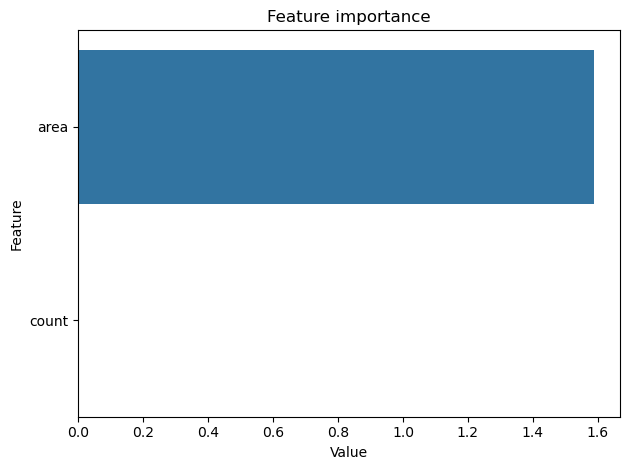

In [33]:
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

**Хорошо:**

- Модель понимает, что чем больше площадь, тем больше метро требуется.

**Плохо:**

- Модель не учитывает плотность населения.
- Модель не учитывает удаленность поселения.
- Модель не учитывает жилую площадь и тип построек. 

**Метрика на кросс валидации 1.28.**

**Анализ НАО**

In [34]:
model.predict(mt_district_full.query('district in @nao')[['count', 'area']]).round()

array([ 2.,  2.,  2., -0., -0., -0.,  2.,  2.,  0.,  2.])

Рассмотрим только те, которые имеют полигоны, так как другие оценки модели неточны.
То есть:

| Название поселения | Метро предикт | Метро реальное | 
| :---------------------- | :---------------------- | :---------------------- |
| гор округ Щербинка     | 2 | 0 (1 мцд)|
| поселение Внуковское   | 2 | 1        |
| поселение Воскресенкое | 2 | 0        |
| поселение Московский   | 2 |   1      |
| поселение Мосрентген   | 2 |   1      |
| поселение Сосенское    | 2 |   4      |

### Добавим еще признаков...

**Distance**

In [35]:
def find_distance(row):
    try:
        geometry = row['geom']
        x, y = get_lat_lon(pd.Series(geometry))
        x_m, y_m = 55.755811, 37.617617
        return np.sqrt((x-x_m)**2+(y-y_m)**2)[0]
    except:
        return -1

In [36]:
mt_district_full['distance_to_center'] = mt_district_full.apply(find_distance, axis=1)

In [37]:
mt_district_full.sample(5)

,district,count,geom,area,count_station_in_district,name_station,distance_to_center
23,Головинский,103100.0,"POLYGON ((37.4644625 55.8471182, 37.4656932 55...",0.001269,1,Водный стадион,0.141201
117,Сокольники,61000.0,"POLYGON ((37.6507092 55.7909339, 37.6504515 55...",0.001467,2,"Сокольники,Сокольники",0.074412
115,Сокол,59200.0,"POLYGON ((37.4868576 55.815334, 37.4873154 55....",0.000503,0,,0.122377
48,Левобережный,53600.0,"POLYGON ((37.4364835 55.8795786, 37.437495 55....",0.000919,2,"Речной вокзал,Беломорская",0.187409
3,Арбат,35000.0,"POLYGON ((37.5720599 55.7520197, 37.5739605 55...",0.000298,6,"Арбатская,Смоленская,Арбатская,Александровский...",0.027982


**Amenities and buildings**

In [38]:
tags_build = [
        {'building' : 'apartments'},{'building' : 'house'}, 
        {'building' : 'retail'}, {'building' : 'office'}, 
        {'building' : 'dormitory'}
]

tags_amenity = [
        {'amenity':'college'},{'amenity':'university'},
        {'amenity':'clinic'},{'amenity':'hospital'},
        {'amenity':'school'}
]

In [39]:
def count_build_amenity(tags, name_tags):
    global mt_district_full
    for tag in tags:
        polygon = ox.features_from_place(cities, tag).reset_index()
        ans = []
        for val in list(mt_district_full['district']):
            k = 0
            for i in range(len(polygon)):
                try:
                    if polygon['geometry'][i] == (polygon['geometry'][i])\
                        .intersection(mt_district_full.loc[mt_district_full['district']== val, 'geom'].reset_index(drop=True)[0]):
                            k += 1
                except:
                    continue

            ans.append([val, k])

        df = pd.DataFrame(ans, columns=['district', f"count_{tag[name_tags]}"])
        mt_district_full = mt_district_full.merge(df, on='district', how='left')
        
count_build_amenity(tags_build, 'building')
count_build_amenity(tags_amenity, 'amenity')

In [40]:
mt_district_full.sample(5)

,district,count,geom,area,count_station_in_district,name_station,distance_to_center,count_apartments,count_house,count_retail,count_office,count_dormitory,count_college,count_university,count_clinic,count_hospital,count_school
79,Печатники,86400.0,"POLYGON ((37.6716027 55.6563638, 37.6716319 55...",0.002637,3,"Печатники,Печатники,Текстильщики",0.112907,0,0,0,0,0,1,0,4,0,0
131,Хорошёво-Мнёвники,171600.0,"POLYGON ((37.4085801 55.7757622, 37.4061353 55...",0.002583,3,"Народное Ополчение,Мнёвники,Терехово",0.154374,0,0,0,0,0,0,1,7,0,1
97,поселение Сосенское,18400.0,"POLYGON ((37.3766651 55.5762426, 37.3769561 55...",0.009514,0,,0.239664,0,0,0,0,0,0,0,0,0,0
100,Преображенское,89300.0,"POLYGON ((37.6988032 55.8013426, 37.6989178 55...",0.000800,2,"Черкизовская,Преображенская площадь",0.112711,0,0,1,0,0,0,0,5,0,4
23,Головинский,103100.0,"POLYGON ((37.4644625 55.8471182, 37.4656932 55...",0.001269,1,Водный стадион,0.141201,0,0,0,0,0,0,0,6,0,0


In [41]:
mt_district_full.describe()

,count,area,count_station_in_district,distance_to_center,count_apartments,count_house,count_retail,count_office,count_dormitory,count_college,count_university,count_clinic,count_hospital,count_school
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,85229.794521,-0.149480,1.698630,-0.024889,0.047945,0.684932,0.020548,0.013699,0.006849,0.267123,0.636986,6.506849,0.226027,0.993151
std,50298.259577,0.359484,2.251038,0.417679,0.318015,8.193146,0.142354,0.116637,0.082761,0.590629,1.461601,10.506646,0.508826,1.880926
min,3100.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49925.000000,0.000601,0.000000,0.064325,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,84250.000000,0.001010,1.000000,0.128786,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,116125.000000,0.001442,2.000000,0.182015,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.750000,7.000000,0.000000,1.000000
max,253300.000000,0.009514,17.000000,0.447033,3.000000,99.000000,1.000000,1.000000,1.000000,3.000000,8.000000,65.000000,2.000000,13.000000


### Вторая модель

In [42]:
df = mt_district_full.drop(axis=0, index=nao_index)\
    .reset_index(drop=True).drop(['geom', 'name_station', 'district'], axis=1)

In [43]:
df.head()

,count,area,count_station_in_district,distance_to_center,count_apartments,count_house,count_retail,count_office,count_dormitory,count_college,count_university,count_clinic,count_hospital,count_school
0,109200.0,0.000815,1,0.078081,0,0,0,0,0,1,1,11,0,0
1,80400.0,0.000743,1,0.065320,0,0,0,0,0,2,2,7,0,0
2,57300.0,0.000473,0,0.128596,0,0,0,0,0,0,0,1,0,0
3,35000.0,0.000298,6,0.027982,0,0,0,0,0,1,1,28,0,1
4,79100.0,0.000667,4,0.090392,0,0,0,0,0,2,2,11,1,4


In [44]:
features = df.drop('count_station_in_district', axis=1)
target = df['count_station_in_district']

In [45]:
features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            train_size=0.75, 
                                                                            random_state=RANDOM_STATE)

In [46]:
model = LinearRegression().fit(features_train, target_train)
cross_val_score(model, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean()*(-1)

0.991261667713994

Посмотрим на какие признаки модель преимущественно обращает внимание. 

In [47]:
feature_importance = model.coef_
feature_importance

array([ 7.60086481e-06,  4.56232732e+00, -3.55517278e+00,  1.04584859e+00,
        4.28016561e-01, -4.73123472e-01, -1.13242749e-14, -2.94578610e+00,
        2.29093870e-01, -5.21941985e-03,  1.13309745e-01, -1.64289605e-01,
       -4.97965818e-02])

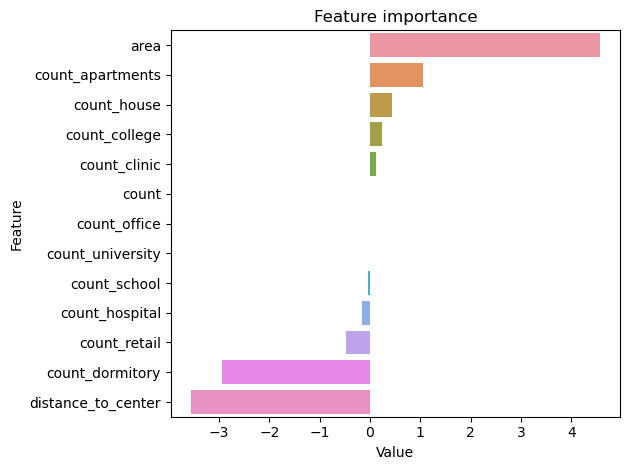

In [48]:
feature_imp = pd.DataFrame(sorted(zip(feature_importance, features_train.columns)), columns=['Value','Feature'])
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('Feature importance')
plt.tight_layout()
plt.show();

Наша модель достаточно хорошо определила зависимости. Метрика на кросс-валидации MAE ~ 1

**Анализ НАО**

In [49]:
mt_district_full.query('district in @nao');

In [50]:
abs(model.predict(mt_district_full.query('district in @nao').drop(['geom', 'district', 'count_station_in_district', 'name_station'], axis=1)).round())

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Модель поняла, что это у нас районы, которые далеко расположены, в которых мало численности населения, в которых мало соц объектов и выдала ожидаемые результаты для районов. При этом для тех районов, где на самом деле есть какие-то объекты - у нас нет данных. Возможно в иной ситуации были бы другие прогнозы.
Попробуем найти информацию о районах и восполним "нули", чтобы получить точный прогноз.

| Название поселения | Метро предикт | Метро реальное | 
| :---------------------- | :---------------------- | :---------------------- |
| гор округ Щербинка     | 0 |     0 (1 мцд)    |
| поселение Внуковское   | 0 |     1    |
| поселение Воскресенкое | 0 |     0    |
| поселение Московский   | 0 |     1    |
| поселение Мосрентген   | 0 |     1    |
| поселение Сосенское    | 0 |     4    |

In [51]:
mt_district_full[mt_district_full['district']=='поселение Сосенское']

,district,count,geom,area,count_station_in_district,name_station,distance_to_center,count_apartments,count_house,count_retail,count_office,count_dormitory,count_college,count_university,count_clinic,count_hospital,count_school
97,поселение Сосенское,18400.0,"POLYGON ((37.3766651 55.5762426, 37.3769561 55...",0.009514,0,,0.239664,0,0,0,0,0,0,0,0,0,0


На основании данных о пос Сосенское - https://nmskao.ru/plany-razvitiya-novomoskovskogo-okruga/poselenie-sosenskoe/

**~(2016-2018):**
- 3 школы
- 4 торговые дома
- 3 офисных комплекса
- 42 дома в составе 9 ЖК
- 1 поликлиника

In [87]:
mt_district_full.loc[mt_district_full['district']=='поселение Сосенское', 'count_hospital'] = 1
mt_district_full.loc[mt_district_full['district']=='поселение Сосенское', 'count_school'] = 3
mt_district_full.loc[mt_district_full['district']=='поселение Сосенское', 'count_office'] = 3
mt_district_full.loc[mt_district_full['district']=='поселение Сосенское', 'count_house'] = 9
mt_district_full.loc[mt_district_full['district']=='поселение Сосенское', 'count_apartments'] = 4

In [88]:
abs(model.predict(mt_district_full.loc[mt_district_full['district']=='поселение Сосенское'].drop(['geom', 'district', 'count_station_in_district', 'name_station'], axis=1)).round())

array([8.])

То есть с учетом поправки данных для районов, о которых в библиотеки osmnx нет достаточного кол-ва информации. Мы получили количество станций - 8. 

В реальности - станций 4. Но планируется построить еще 1 станцию "красной" ветки. И в последствии, новые станции.

### Применим пайплайн

In [89]:
pipeline = Pipeline([
    ('scaler', StandardScaler()), 
    ('linear_regression', LinearRegression())
])

In [90]:
pipeline.fit(features_train, target_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_regression', LinearRegression())])

In [91]:
cross_val_score(pipeline, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean()*(-1)

0.9912616677139937

In [92]:
pipeline.predict(mt_district_full.loc[mt_district_full['district']=='поселение Сосенское'].drop(['geom', 'district', 'count_station_in_district', 'name_station'], axis=1)).round()*(-1)

array([-8.])

**Стандартизация не улучшила результат.** <br>
**Попробуем еще одну линейную модель.**

In [93]:
parameters_pls = {'pls__n_components':np.arange(1,14,1)}
plsr_pipe = Pipeline([('scaler', MinMaxScaler()), ('pls', PLSRegression())])
 
plsr = GridSearchCV(plsr_pipe, parameters_pls, scoring = 'neg_mean_absolute_error')
plsr.fit(features_train, target_train)
print(plsr.best_estimator_)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('pls', PLSRegression(n_components=6))])


In [94]:
pipeline_plsr = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pls', PLSRegression(n_components=1))
])
pipeline_plsr.fit(features_train, target_train)
cross_val_score(pipeline_plsr, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean()*(-1)

1.1494210258462858

In [95]:
# предикт для НАО
pipeline_plsr.predict(mt_district_full.loc[mt_district_full['district']=='поселение Сосенское'].drop(['geom', 'district', 'count_station_in_district', 'name_station'], axis=1)).round()

array([[5.]])

Результат не стал лучше: ~ 1.14 на кросс-валидации.<br>
Для НАО предикт точнее - 5 станций.

### Попробуем бустинг

In [96]:
boost = CatBoostRegressor(iterations=3000,
                          early_stopping_rounds=100,
                          grow_policy = 'Depthwise',
                          depth=8,
                          loss_function='MAE',
                          random_state=RANDOM_STATE,
                          l2_leaf_reg = 1,
                          learning_rate=0.03,
                          verbose=10)
    
params = {'l2_leaf_reg':[1,4,8],
          'learning_rate': [0.01,0.03,0.5,0.1],
          'depth':[6,8,10],
          'iterations': [10, 100, 500, 1000, 3000]
         }

grid_boost = boost.grid_search(params, features_train, target_train, train_size=0.75)

0:	learn: 1.6894729	test: 1.7234608	best: 1.7234608 (0)	total: 3.62ms	remaining: 32.6ms
9:	learn: 1.5995707	test: 1.6473844	best: 1.6473844 (9)	total: 44.4ms	remaining: 0us

bestTest = 1.647384442
bestIteration = 9

0:	loss: 1.6473844	best: 1.6473844 (0)	total: 50.7ms	remaining: 9.08s
0:	learn: 1.6736834	test: 1.7088454	best: 1.7088454 (0)	total: 1.65ms	remaining: 14.8ms
9:	learn: 1.4130414	test: 1.5222087	best: 1.5222087 (9)	total: 20.4ms	remaining: 0us

bestTest = 1.522208725
bestIteration = 9

1:	loss: 1.5222087	best: 1.5222087 (1)	total: 71.9ms	remaining: 6.39s
0:	learn: 1.3421043	test: 1.4038452	best: 1.4038452 (0)	total: 1.39ms	remaining: 12.5ms
9:	learn: 0.3865637	test: 1.1056932	best: 1.1056932 (9)	total: 16.1ms	remaining: 0us

bestTest = 1.105693152
bestIteration = 9

2:	loss: 1.1056932	best: 1.1056932 (2)	total: 88.6ms	remaining: 5.22s
0:	learn: 1.6184203	test: 1.6576915	best: 1.6576915 (0)	total: 1.25ms	remaining: 11.3ms
9:	learn: 0.9969817	test: 1.2329834	best: 1.2329834 (9

99:	learn: 0.9792562	test: 1.1105789	best: 1.1105789 (99)	total: 155ms	remaining: 0us

bestTest = 1.110578875
bestIteration = 99

16:	loss: 1.1105789	best: 0.9115589 (13)	total: 1.11s	remaining: 10.6s
0:	learn: 1.6657887	test: 1.6973069	best: 1.6973069 (0)	total: 1.09ms	remaining: 108ms
10:	learn: 1.3778818	test: 1.4850067	best: 1.4850067 (10)	total: 19.5ms	remaining: 158ms
20:	learn: 1.1800994	test: 1.3176601	best: 1.3176601 (20)	total: 34ms	remaining: 128ms
30:	learn: 0.9988893	test: 1.1593626	best: 1.1593626 (30)	total: 46.7ms	remaining: 104ms
40:	learn: 0.8769386	test: 1.0673328	best: 1.0673328 (40)	total: 66.5ms	remaining: 95.7ms
50:	learn: 0.7827217	test: 1.0246811	best: 1.0246811 (50)	total: 82.8ms	remaining: 79.6ms
60:	learn: 0.6996222	test: 0.9988745	best: 0.9988745 (60)	total: 96.1ms	remaining: 61.5ms
70:	learn: 0.6332942	test: 0.9838151	best: 0.9826563 (67)	total: 109ms	remaining: 44.4ms
80:	learn: 0.5767262	test: 0.9707320	best: 0.9707320 (80)	total: 122ms	remaining: 28.5ms

90:	learn: 1.0248496	test: 1.1453142	best: 1.1453142 (90)	total: 146ms	remaining: 654ms
100:	learn: 0.9765505	test: 1.0990510	best: 1.0990510 (100)	total: 164ms	remaining: 648ms
110:	learn: 0.9352919	test: 1.0618462	best: 1.0618462 (110)	total: 178ms	remaining: 623ms
120:	learn: 0.8939747	test: 1.0363358	best: 1.0363358 (120)	total: 193ms	remaining: 604ms
130:	learn: 0.8595733	test: 1.0249074	best: 1.0249074 (130)	total: 212ms	remaining: 598ms
140:	learn: 0.8257811	test: 1.0122546	best: 1.0122546 (140)	total: 225ms	remaining: 572ms
150:	learn: 0.7942135	test: 0.9996810	best: 0.9996810 (150)	total: 239ms	remaining: 552ms
160:	learn: 0.7661464	test: 0.9885463	best: 0.9885463 (160)	total: 255ms	remaining: 537ms
170:	learn: 0.7371757	test: 0.9766079	best: 0.9766079 (170)	total: 268ms	remaining: 515ms
180:	learn: 0.7121939	test: 0.9722089	best: 0.9722089 (180)	total: 280ms	remaining: 494ms
190:	learn: 0.6894260	test: 0.9637680	best: 0.9637680 (190)	total: 295ms	remaining: 478ms
200:	learn: 

70:	learn: 0.0840547	test: 1.1820056	best: 1.1056932 (9)	total: 204ms	remaining: 1.23s
80:	learn: 0.0648564	test: 1.1988597	best: 1.1056932 (9)	total: 226ms	remaining: 1.17s
90:	learn: 0.0581354	test: 1.2018137	best: 1.1056932 (9)	total: 237ms	remaining: 1.06s
100:	learn: 0.0523029	test: 1.2024799	best: 1.1056932 (9)	total: 246ms	remaining: 972ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.105693152
bestIteration = 9

26:	loss: 1.1056932	best: 0.8043408 (23)	total: 4.46s	remaining: 25.3s
0:	learn: 1.6184203	test: 1.6576915	best: 1.6576915 (0)	total: 1.04ms	remaining: 519ms
10:	learn: 0.9418523	test: 1.2111225	best: 1.2111225 (10)	total: 19ms	remaining: 846ms
20:	learn: 0.6158488	test: 1.0934922	best: 1.0934922 (20)	total: 40ms	remaining: 912ms
30:	learn: 0.4826485	test: 1.0298480	best: 1.0261566 (27)	total: 53ms	remaining: 802ms
40:	learn: 0.3731461	test: 1.0327354	best: 1.0207283 (35)	total: 67.7ms	remaining: 758ms
50:	learn: 0.3094902	test: 1.0011421	best: 1.

200:	learn: 0.2666787	test: 0.9215762	best: 0.9209822 (198)	total: 332ms	remaining: 493ms
210:	learn: 0.2497003	test: 0.9186923	best: 0.9186923 (210)	total: 352ms	remaining: 482ms
220:	learn: 0.2325327	test: 0.9174528	best: 0.9173795 (219)	total: 370ms	remaining: 467ms
230:	learn: 0.2167429	test: 0.9114829	best: 0.9112643 (229)	total: 382ms	remaining: 445ms
240:	learn: 0.2064378	test: 0.9094856	best: 0.9094856 (240)	total: 416ms	remaining: 447ms
250:	learn: 0.1963121	test: 0.9072532	best: 0.9072532 (250)	total: 447ms	remaining: 444ms
260:	learn: 0.1882231	test: 0.8998319	best: 0.8998319 (260)	total: 484ms	remaining: 444ms
270:	learn: 0.1759305	test: 0.8958117	best: 0.8940893 (266)	total: 520ms	remaining: 439ms
280:	learn: 0.1651626	test: 0.8944444	best: 0.8940893 (266)	total: 557ms	remaining: 434ms
290:	learn: 0.1599336	test: 0.8924071	best: 0.8914330 (288)	total: 589ms	remaining: 423ms
300:	learn: 0.1514222	test: 0.8902491	best: 0.8890114 (297)	total: 623ms	remaining: 412ms
310:	learn

350:	learn: 0.4445588	test: 0.9645091	best: 0.9641506 (347)	total: 602ms	remaining: 255ms
360:	learn: 0.4343002	test: 0.9632335	best: 0.9632335 (360)	total: 627ms	remaining: 241ms
370:	learn: 0.4257823	test: 0.9611354	best: 0.9609761 (369)	total: 643ms	remaining: 223ms
380:	learn: 0.4171192	test: 0.9621047	best: 0.9607110 (377)	total: 657ms	remaining: 205ms
390:	learn: 0.4098702	test: 0.9600434	best: 0.9600434 (390)	total: 672ms	remaining: 187ms
400:	learn: 0.4020510	test: 0.9610749	best: 0.9598228 (391)	total: 685ms	remaining: 169ms
410:	learn: 0.3922847	test: 0.9572557	best: 0.9572557 (410)	total: 698ms	remaining: 151ms
420:	learn: 0.3844093	test: 0.9565661	best: 0.9563638 (419)	total: 714ms	remaining: 134ms
430:	learn: 0.3740449	test: 0.9556473	best: 0.9553111 (429)	total: 728ms	remaining: 117ms
440:	learn: 0.3656379	test: 0.9514483	best: 0.9511966 (439)	total: 744ms	remaining: 99.5ms
450:	learn: 0.3585419	test: 0.9494624	best: 0.9492126 (447)	total: 764ms	remaining: 83ms
460:	learn

310:	learn: 0.0000009	test: 1.1592056	best: 1.1592052 (293)	total: 450ms	remaining: 273ms
320:	learn: 0.0000003	test: 1.1592076	best: 1.1592052 (293)	total: 464ms	remaining: 259ms
330:	learn: 0.0000002	test: 1.1592076	best: 1.1592052 (293)	total: 477ms	remaining: 244ms
340:	learn: 0.0000000	test: 1.1592072	best: 1.1592052 (293)	total: 492ms	remaining: 229ms
350:	learn: 0.0000000	test: 1.1592075	best: 1.1592052 (293)	total: 509ms	remaining: 216ms
360:	learn: 0.0000001	test: 1.1592069	best: 1.1592052 (293)	total: 523ms	remaining: 202ms
370:	learn: 0.0000000	test: 1.1592071	best: 1.1592052 (293)	total: 536ms	remaining: 186ms
380:	learn: 0.0000000	test: 1.1592073	best: 1.1592052 (293)	total: 548ms	remaining: 171ms
390:	learn: 0.0000000	test: 1.1592076	best: 1.1592052 (293)	total: 559ms	remaining: 156ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.159205169
bestIteration = 293

34:	loss: 1.1592052	best: 0.8043408 (23)	total: 9.14s	remaining: 37.9s
0:	learn: 1.5921045

670:	learn: 0.2625298	test: 0.8771712	best: 0.8756548 (666)	total: 1.82s	remaining: 894ms
680:	learn: 0.2580209	test: 0.8756197	best: 0.8754080 (676)	total: 1.85s	remaining: 868ms
690:	learn: 0.2537151	test: 0.8730453	best: 0.8730453 (690)	total: 1.87s	remaining: 836ms
700:	learn: 0.2502449	test: 0.8716619	best: 0.8715500 (695)	total: 1.89s	remaining: 808ms
710:	learn: 0.2469141	test: 0.8710371	best: 0.8706600 (708)	total: 1.91s	remaining: 777ms
720:	learn: 0.2440788	test: 0.8697994	best: 0.8697489 (718)	total: 1.93s	remaining: 747ms
730:	learn: 0.2393246	test: 0.8700231	best: 0.8689488 (723)	total: 1.95s	remaining: 718ms
740:	learn: 0.2347872	test: 0.8703953	best: 0.8689488 (723)	total: 1.97s	remaining: 689ms
750:	learn: 0.2310050	test: 0.8691330	best: 0.8689488 (723)	total: 1.99s	remaining: 659ms
760:	learn: 0.2267124	test: 0.8693226	best: 0.8689488 (723)	total: 2.01s	remaining: 631ms
770:	learn: 0.2231636	test: 0.8686828	best: 0.8686828 (770)	total: 2.03s	remaining: 603ms
780:	learn

20:	learn: 0.6158488	test: 1.0934922	best: 1.0934922 (20)	total: 55.7ms	remaining: 2.6s
30:	learn: 0.4826485	test: 1.0298480	best: 1.0261566 (27)	total: 71.9ms	remaining: 2.25s
40:	learn: 0.3731461	test: 1.0327354	best: 1.0207283 (35)	total: 93.7ms	remaining: 2.19s
50:	learn: 0.3094902	test: 1.0011421	best: 1.0001648 (49)	total: 109ms	remaining: 2.03s
60:	learn: 0.2590844	test: 1.0242171	best: 0.9975182 (51)	total: 121ms	remaining: 1.86s
70:	learn: 0.2147528	test: 1.0181355	best: 0.9975182 (51)	total: 137ms	remaining: 1.8s
80:	learn: 0.1951571	test: 1.0124417	best: 0.9975182 (51)	total: 160ms	remaining: 1.82s
90:	learn: 0.1754405	test: 1.0059893	best: 0.9975182 (51)	total: 175ms	remaining: 1.74s
100:	learn: 0.1628966	test: 1.0105205	best: 0.9975182 (51)	total: 190ms	remaining: 1.69s
110:	learn: 0.1519857	test: 1.0104294	best: 0.9975182 (51)	total: 206ms	remaining: 1.65s
120:	learn: 0.1406986	test: 1.0097570	best: 0.9975182 (51)	total: 226ms	remaining: 1.65s
130:	learn: 0.1294881	test: 

780:	learn: 0.2021047	test: 0.8768612	best: 0.8768612 (780)	total: 1.5s	remaining: 421ms
790:	learn: 0.1985565	test: 0.8763545	best: 0.8763545 (790)	total: 1.53s	remaining: 405ms
800:	learn: 0.1946572	test: 0.8727688	best: 0.8727688 (800)	total: 1.55s	remaining: 386ms
810:	learn: 0.1913659	test: 0.8722845	best: 0.8717756 (807)	total: 1.57s	remaining: 366ms
820:	learn: 0.1884252	test: 0.8708208	best: 0.8706731 (818)	total: 1.58s	remaining: 346ms
830:	learn: 0.1861843	test: 0.8694859	best: 0.8693899 (829)	total: 1.6s	remaining: 326ms
840:	learn: 0.1824950	test: 0.8669811	best: 0.8669811 (840)	total: 1.62s	remaining: 306ms
850:	learn: 0.1787457	test: 0.8668244	best: 0.8667352 (849)	total: 1.63s	remaining: 286ms
860:	learn: 0.1753687	test: 0.8647317	best: 0.8647317 (860)	total: 1.65s	remaining: 267ms
870:	learn: 0.1725303	test: 0.8639757	best: 0.8639757 (870)	total: 1.67s	remaining: 247ms
880:	learn: 0.1693969	test: 0.8642024	best: 0.8639590 (871)	total: 1.68s	remaining: 227ms
890:	learn: 

120:	learn: 0.1283376	test: 0.9189898	best: 0.9164733 (110)	total: 243ms	remaining: 1.76s
130:	learn: 0.1187793	test: 0.9187793	best: 0.9164733 (110)	total: 277ms	remaining: 1.84s
140:	learn: 0.1088689	test: 0.9207126	best: 0.9164733 (110)	total: 295ms	remaining: 1.8s
150:	learn: 0.1039155	test: 0.9176657	best: 0.9164733 (110)	total: 310ms	remaining: 1.74s
160:	learn: 0.0962430	test: 0.9222709	best: 0.9164733 (110)	total: 332ms	remaining: 1.73s
170:	learn: 0.0927337	test: 0.9208669	best: 0.9164733 (110)	total: 347ms	remaining: 1.68s
180:	learn: 0.0908307	test: 0.9223260	best: 0.9164733 (110)	total: 360ms	remaining: 1.63s
190:	learn: 0.0883245	test: 0.9208707	best: 0.9164733 (110)	total: 373ms	remaining: 1.58s
200:	learn: 0.0803338	test: 0.9169026	best: 0.9164733 (110)	total: 396ms	remaining: 1.57s
210:	learn: 0.0758967	test: 0.9167132	best: 0.9164733 (110)	total: 415ms	remaining: 1.55s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.916473318
bestIteration = 110

4

810:	learn: 0.1754368	test: 0.9099708	best: 0.9097540 (804)	total: 1.63s	remaining: 379ms
820:	learn: 0.1718746	test: 0.9094618	best: 0.9091726 (813)	total: 1.65s	remaining: 360ms
830:	learn: 0.1695717	test: 0.9074695	best: 0.9074695 (830)	total: 1.67s	remaining: 340ms
840:	learn: 0.1679825	test: 0.9074814	best: 0.9072784 (837)	total: 1.69s	remaining: 319ms
850:	learn: 0.1662513	test: 0.9071003	best: 0.9071003 (850)	total: 1.7s	remaining: 298ms
860:	learn: 0.1640213	test: 0.9053271	best: 0.9050957 (855)	total: 1.72s	remaining: 277ms
870:	learn: 0.1603994	test: 0.9038814	best: 0.9037133 (868)	total: 1.74s	remaining: 258ms
880:	learn: 0.1582383	test: 0.9039155	best: 0.9037133 (868)	total: 1.76s	remaining: 237ms
890:	learn: 0.1545520	test: 0.9029102	best: 0.9029102 (890)	total: 1.78s	remaining: 218ms
900:	learn: 0.1521200	test: 0.9029810	best: 0.9025613 (895)	total: 1.8s	remaining: 198ms
910:	learn: 0.1496244	test: 0.9039533	best: 0.9025613 (895)	total: 1.82s	remaining: 178ms
920:	learn: 

280:	learn: 0.0000563	test: 1.1592234	best: 1.1592197 (262)	total: 475ms	remaining: 1.22s
290:	learn: 0.0000070	test: 1.1592052	best: 1.1592052 (290)	total: 503ms	remaining: 1.22s
300:	learn: 0.0000009	test: 1.1592053	best: 1.1592052 (293)	total: 519ms	remaining: 1.21s
310:	learn: 0.0000009	test: 1.1592056	best: 1.1592052 (293)	total: 529ms	remaining: 1.17s
320:	learn: 0.0000003	test: 1.1592076	best: 1.1592052 (293)	total: 541ms	remaining: 1.15s
330:	learn: 0.0000002	test: 1.1592076	best: 1.1592052 (293)	total: 560ms	remaining: 1.13s
340:	learn: 0.0000000	test: 1.1592072	best: 1.1592052 (293)	total: 573ms	remaining: 1.11s
350:	learn: 0.0000000	test: 1.1592075	best: 1.1592052 (293)	total: 582ms	remaining: 1.08s
360:	learn: 0.0000001	test: 1.1592069	best: 1.1592052 (293)	total: 592ms	remaining: 1.05s
370:	learn: 0.0000000	test: 1.1592071	best: 1.1592052 (293)	total: 605ms	remaining: 1.02s
380:	learn: 0.0000000	test: 1.1592073	best: 1.1592052 (293)	total: 622ms	remaining: 1.01s
390:	learn

630:	learn: 0.2770085	test: 0.8762109	best: 0.8760560 (628)	total: 1.22s	remaining: 4.6s
640:	learn: 0.2745194	test: 0.8766282	best: 0.8758212 (633)	total: 1.26s	remaining: 4.63s
650:	learn: 0.2719919	test: 0.8770669	best: 0.8758212 (633)	total: 1.28s	remaining: 4.61s
660:	learn: 0.2681379	test: 0.8757648	best: 0.8757648 (660)	total: 1.29s	remaining: 4.57s
670:	learn: 0.2625298	test: 0.8771712	best: 0.8756548 (666)	total: 1.3s	remaining: 4.53s
680:	learn: 0.2580209	test: 0.8756197	best: 0.8754080 (676)	total: 1.33s	remaining: 4.53s
690:	learn: 0.2537151	test: 0.8730453	best: 0.8730453 (690)	total: 1.35s	remaining: 4.5s
700:	learn: 0.2502449	test: 0.8716619	best: 0.8715500 (695)	total: 1.36s	remaining: 4.46s
710:	learn: 0.2469141	test: 0.8710371	best: 0.8706600 (708)	total: 1.38s	remaining: 4.43s
720:	learn: 0.2440788	test: 0.8697994	best: 0.8697489 (718)	total: 1.4s	remaining: 4.42s
730:	learn: 0.2393246	test: 0.8700231	best: 0.8689488 (723)	total: 1.41s	remaining: 4.39s
740:	learn: 0.

60:	learn: 0.0884236	test: 1.1830736	best: 1.1056932 (9)	total: 110ms	remaining: 5.28s
70:	learn: 0.0840547	test: 1.1820056	best: 1.1056932 (9)	total: 131ms	remaining: 5.4s
80:	learn: 0.0648564	test: 1.1988597	best: 1.1056932 (9)	total: 147ms	remaining: 5.29s
90:	learn: 0.0581354	test: 1.2018137	best: 1.1056932 (9)	total: 162ms	remaining: 5.18s
100:	learn: 0.0523029	test: 1.2024799	best: 1.1056932 (9)	total: 174ms	remaining: 4.99s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.105693152
bestIteration = 9

50:	loss: 1.1056932	best: 0.8043408 (23)	total: 23.9s	remaining: 1m
0:	learn: 1.6184203	test: 1.6576915	best: 1.6576915 (0)	total: 1.5ms	remaining: 4.5s
10:	learn: 0.9418523	test: 1.2111225	best: 1.2111225 (10)	total: 15.8ms	remaining: 4.28s
20:	learn: 0.6158488	test: 1.0934922	best: 1.0934922 (20)	total: 37.4ms	remaining: 5.3s
30:	learn: 0.4826485	test: 1.0298480	best: 1.0261566 (27)	total: 54.3ms	remaining: 5.2s
40:	learn: 0.3731461	test: 1.0327354	best: 1.0207

760:	learn: 0.2102076	test: 0.8785354	best: 0.8784549 (759)	total: 1.45s	remaining: 4.25s
770:	learn: 0.2065535	test: 0.8782193	best: 0.8782193 (770)	total: 1.48s	remaining: 4.26s
780:	learn: 0.2021047	test: 0.8768612	best: 0.8768612 (780)	total: 1.5s	remaining: 4.26s
790:	learn: 0.1985565	test: 0.8763545	best: 0.8763545 (790)	total: 1.51s	remaining: 4.23s
800:	learn: 0.1946572	test: 0.8727688	best: 0.8727688 (800)	total: 1.53s	remaining: 4.2s
810:	learn: 0.1913659	test: 0.8722845	best: 0.8717756 (807)	total: 1.55s	remaining: 4.19s
820:	learn: 0.1884252	test: 0.8708208	best: 0.8706731 (818)	total: 1.57s	remaining: 4.16s
830:	learn: 0.1861843	test: 0.8694859	best: 0.8693899 (829)	total: 1.59s	remaining: 4.14s
840:	learn: 0.1824950	test: 0.8669811	best: 0.8669811 (840)	total: 1.61s	remaining: 4.13s
850:	learn: 0.1787457	test: 0.8668244	best: 0.8667352 (849)	total: 1.62s	remaining: 4.1s
860:	learn: 0.1753687	test: 0.8647317	best: 0.8647317 (860)	total: 1.64s	remaining: 4.07s
870:	learn: 0

380:	learn: 0.1177044	test: 0.9025091	best: 0.8890114 (297)	total: 773ms	remaining: 5.31s
390:	learn: 0.1130064	test: 0.9036556	best: 0.8890114 (297)	total: 800ms	remaining: 5.34s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8890114172
bestIteration = 297

53:	loss: 0.8890114	best: 0.8043408 (23)	total: 27.9s	remaining: 1m 5s
0:	learn: 1.2236834	test: 1.4038454	best: 1.4038454 (0)	total: 1.3ms	remaining: 3.89s
10:	learn: 0.3124219	test: 1.1868972	best: 1.1823902 (7)	total: 19.1ms	remaining: 5.18s
20:	learn: 0.1359190	test: 1.2996004	best: 1.1449331 (13)	total: 43.9ms	remaining: 6.23s
30:	learn: 0.0973312	test: 1.3043857	best: 1.1449331 (13)	total: 59.1ms	remaining: 5.66s
40:	learn: 0.0780643	test: 1.3034328	best: 1.1449331 (13)	total: 74.2ms	remaining: 5.36s
50:	learn: 0.0528685	test: 1.3421241	best: 1.1449331 (13)	total: 89.6ms	remaining: 5.18s
60:	learn: 0.0464836	test: 1.3444528	best: 1.1449331 (13)	total: 108ms	remaining: 5.19s
70:	learn: 0.0429023	test: 1.3

570:	learn: 0.2754869	test: 0.9334576	best: 0.9331746 (568)	total: 1.06s	remaining: 4.5s
580:	learn: 0.2686574	test: 0.9339507	best: 0.9331469 (571)	total: 1.09s	remaining: 4.55s
590:	learn: 0.2628304	test: 0.9332639	best: 0.9330089 (588)	total: 1.11s	remaining: 4.53s
600:	learn: 0.2572371	test: 0.9318753	best: 0.9318753 (600)	total: 1.12s	remaining: 4.49s
610:	learn: 0.2522334	test: 0.9295548	best: 0.9291321 (609)	total: 1.14s	remaining: 4.45s
620:	learn: 0.2475085	test: 0.9268379	best: 0.9268289 (618)	total: 1.15s	remaining: 4.42s
630:	learn: 0.2418949	test: 0.9255276	best: 0.9255276 (630)	total: 1.17s	remaining: 4.38s
640:	learn: 0.2368397	test: 0.9235442	best: 0.9234120 (638)	total: 1.18s	remaining: 4.35s
650:	learn: 0.2314007	test: 0.9214246	best: 0.9214228 (649)	total: 1.2s	remaining: 4.32s
660:	learn: 0.2271309	test: 0.9212433	best: 0.9209988 (659)	total: 1.21s	remaining: 4.29s
670:	learn: 0.2228091	test: 0.9198067	best: 0.9193732 (669)	total: 1.23s	remaining: 4.27s
680:	learn: 

20:	learn: 0.1393645	test: 1.2254949	best: 1.1844943 (8)	total: 69.2ms	remaining: 9.81s
30:	learn: 0.0635236	test: 1.2183155	best: 1.1844943 (8)	total: 93.5ms	remaining: 8.96s
40:	learn: 0.0350673	test: 1.1878845	best: 1.1844943 (8)	total: 120ms	remaining: 8.65s
50:	learn: 0.0288433	test: 1.1924169	best: 1.1844943 (8)	total: 143ms	remaining: 8.28s
60:	learn: 0.0260806	test: 1.1918132	best: 1.1844943 (8)	total: 156ms	remaining: 7.49s
70:	learn: 0.0227497	test: 1.1906418	best: 1.1844943 (8)	total: 179ms	remaining: 7.37s
80:	learn: 0.0122898	test: 1.1646839	best: 1.1646839 (80)	total: 195ms	remaining: 7.04s
90:	learn: 0.0111849	test: 1.1642513	best: 1.1642441 (81)	total: 215ms	remaining: 6.88s
100:	learn: 0.0099362	test: 1.1629812	best: 1.1629812 (100)	total: 238ms	remaining: 6.83s
110:	learn: 0.0097400	test: 1.1625146	best: 1.1625146 (110)	total: 250ms	remaining: 6.52s
120:	learn: 0.0091142	test: 1.1608323	best: 1.1608083 (116)	total: 282ms	remaining: 6.71s
130:	learn: 0.0085036	test: 1.

9:	learn: 0.9658613	test: 1.2128675	best: 1.2128675 (9)	total: 50.1ms	remaining: 0us

bestTest = 1.212867465
bestIteration = 9

71:	loss: 1.2128675	best: 0.8043408 (23)	total: 32.9s	remaining: 49.4s
0:	learn: 1.6882887	test: 1.7223069	best: 1.7223069 (0)	total: 7.99ms	remaining: 791ms
10:	learn: 1.5789326	test: 1.6373356	best: 1.6373356 (10)	total: 64.7ms	remaining: 524ms
20:	learn: 1.4805115	test: 1.5628054	best: 1.5628054 (20)	total: 95.3ms	remaining: 359ms
30:	learn: 1.3914911	test: 1.5010704	best: 1.5010704 (30)	total: 121ms	remaining: 270ms
40:	learn: 1.3053049	test: 1.4388444	best: 1.4388444 (40)	total: 153ms	remaining: 220ms
50:	learn: 1.2239489	test: 1.3817905	best: 1.3817905 (50)	total: 196ms	remaining: 188ms
60:	learn: 1.1402740	test: 1.3186249	best: 1.3186249 (60)	total: 245ms	remaining: 157ms
70:	learn: 1.0675629	test: 1.2705897	best: 1.2705897 (70)	total: 274ms	remaining: 112ms
80:	learn: 1.0039042	test: 1.2279859	best: 1.2279859 (80)	total: 306ms	remaining: 71.7ms
90:	lea

10:	learn: 1.5791473	test: 1.6480808	best: 1.6480808 (10)	total: 46.3ms	remaining: 374ms
20:	learn: 1.4693231	test: 1.5700914	best: 1.5700914 (20)	total: 102ms	remaining: 384ms
30:	learn: 1.3823275	test: 1.5050223	best: 1.5050223 (30)	total: 152ms	remaining: 339ms
40:	learn: 1.2972555	test: 1.4413950	best: 1.4413950 (40)	total: 182ms	remaining: 262ms
50:	learn: 1.2136902	test: 1.3824809	best: 1.3824809 (50)	total: 206ms	remaining: 198ms
60:	learn: 1.1376292	test: 1.3212266	best: 1.3212266 (60)	total: 229ms	remaining: 147ms
70:	learn: 1.0668887	test: 1.2656942	best: 1.2656942 (70)	total: 264ms	remaining: 108ms
80:	learn: 1.0038642	test: 1.2130091	best: 1.2130091 (80)	total: 296ms	remaining: 69.5ms
90:	learn: 0.9439257	test: 1.1759222	best: 1.1759222 (90)	total: 321ms	remaining: 31.7ms
99:	learn: 0.8985186	test: 1.1378024	best: 1.1378024 (99)	total: 341ms	remaining: 0us

bestTest = 1.137802362
bestIteration = 99

80:	loss: 1.1378024	best: 0.8043408 (23)	total: 35.8s	remaining: 43.8s
0:	l

470:	learn: 0.2353538	test: 0.9910883	best: 0.9909925 (469)	total: 1.82s	remaining: 112ms
480:	learn: 0.2284324	test: 0.9878436	best: 0.9878436 (480)	total: 1.85s	remaining: 73.1ms
490:	learn: 0.2215068	test: 0.9841614	best: 0.9841223 (489)	total: 1.88s	remaining: 34.4ms
499:	learn: 0.2165358	test: 0.9821327	best: 0.9821327 (499)	total: 1.9s	remaining: 0us

bestTest = 0.9821326632
bestIteration = 499

84:	loss: 0.9821327	best: 0.8043408 (23)	total: 38.5s	remaining: 43.1s
0:	learn: 1.6701308	test: 1.7053838	best: 1.7053838 (0)	total: 3.59ms	remaining: 1.79s
10:	learn: 1.3593867	test: 1.4687592	best: 1.4687592 (10)	total: 30.5ms	remaining: 1.36s
20:	learn: 1.1400595	test: 1.2620403	best: 1.2620403 (20)	total: 50.3ms	remaining: 1.15s
30:	learn: 0.9572559	test: 1.1409632	best: 1.1409632 (30)	total: 74.7ms	remaining: 1.13s
40:	learn: 0.8015390	test: 1.0872655	best: 1.0872655 (40)	total: 99.5ms	remaining: 1.11s
50:	learn: 0.6916405	test: 1.0560728	best: 1.0560728 (50)	total: 134ms	remaining:

100:	learn: 0.9080970	test: 1.1282511	best: 1.1282511 (100)	total: 429ms	remaining: 1.7s
110:	learn: 0.8659018	test: 1.1056006	best: 1.1056006 (110)	total: 477ms	remaining: 1.67s
120:	learn: 0.8177137	test: 1.0800476	best: 1.0800476 (120)	total: 527ms	remaining: 1.65s
130:	learn: 0.7803868	test: 1.0773877	best: 1.0773877 (130)	total: 580ms	remaining: 1.63s
140:	learn: 0.7427938	test: 1.0647227	best: 1.0647227 (140)	total: 615ms	remaining: 1.57s
150:	learn: 0.7089061	test: 1.0550483	best: 1.0550483 (150)	total: 650ms	remaining: 1.5s
160:	learn: 0.6745172	test: 1.0550335	best: 1.0543140 (151)	total: 701ms	remaining: 1.48s
170:	learn: 0.6427262	test: 1.0456469	best: 1.0453419 (169)	total: 745ms	remaining: 1.43s
180:	learn: 0.6150483	test: 1.0365035	best: 1.0365035 (180)	total: 797ms	remaining: 1.41s
190:	learn: 0.5870351	test: 1.0313697	best: 1.0313697 (190)	total: 849ms	remaining: 1.37s
200:	learn: 0.5589844	test: 1.0234265	best: 1.0234265 (200)	total: 899ms	remaining: 1.34s
210:	learn: 

30:	learn: 0.0459666	test: 1.0700531	best: 1.0700531 (30)	total: 93.1ms	remaining: 1.41s
40:	learn: 0.0315860	test: 1.0932750	best: 1.0700531 (30)	total: 122ms	remaining: 1.37s
50:	learn: 0.0265918	test: 1.1095358	best: 1.0700531 (30)	total: 143ms	remaining: 1.26s
60:	learn: 0.0258440	test: 1.1098601	best: 1.0700531 (30)	total: 156ms	remaining: 1.12s
70:	learn: 0.0242265	test: 1.1098731	best: 1.0700531 (30)	total: 167ms	remaining: 1.01s
80:	learn: 0.0167891	test: 1.1071178	best: 1.0700531 (30)	total: 184ms	remaining: 954ms
90:	learn: 0.0091038	test: 1.0940528	best: 1.0700531 (30)	total: 196ms	remaining: 881ms
100:	learn: 0.0041294	test: 1.0966671	best: 1.0700531 (30)	total: 208ms	remaining: 821ms
110:	learn: 0.0033118	test: 1.0953450	best: 1.0700531 (30)	total: 222ms	remaining: 777ms
120:	learn: 0.0015296	test: 1.0948122	best: 1.0700531 (30)	total: 234ms	remaining: 734ms
130:	learn: 0.0010103	test: 1.0945947	best: 1.0700531 (30)	total: 249ms	remaining: 702ms
Stopped by overfitting dete

110:	learn: 0.3171415	test: 0.9947436	best: 0.9944117 (106)	total: 569ms	remaining: 1.99s
120:	learn: 0.2881087	test: 0.9948332	best: 0.9916518 (113)	total: 622ms	remaining: 1.95s
130:	learn: 0.2618275	test: 0.9925838	best: 0.9916518 (113)	total: 664ms	remaining: 1.87s
140:	learn: 0.2375334	test: 0.9856460	best: 0.9856460 (140)	total: 701ms	remaining: 1.78s
150:	learn: 0.2153734	test: 0.9803190	best: 0.9803190 (150)	total: 732ms	remaining: 1.69s
160:	learn: 0.1972937	test: 0.9739903	best: 0.9739903 (160)	total: 758ms	remaining: 1.59s
170:	learn: 0.1794335	test: 0.9745512	best: 0.9739903 (160)	total: 799ms	remaining: 1.54s
180:	learn: 0.1663384	test: 0.9663676	best: 0.9663676 (180)	total: 830ms	remaining: 1.46s
190:	learn: 0.1531294	test: 0.9649973	best: 0.9641851 (189)	total: 856ms	remaining: 1.38s
200:	learn: 0.1424049	test: 0.9561850	best: 0.9560827 (198)	total: 880ms	remaining: 1.31s
210:	learn: 0.1310908	test: 0.9549055	best: 0.9549055 (210)	total: 907ms	remaining: 1.24s
220:	learn

100:	learn: 0.8902762	test: 1.1712256	best: 1.1712256 (100)	total: 282ms	remaining: 2.51s
110:	learn: 0.8414142	test: 1.1467811	best: 1.1467811 (110)	total: 325ms	remaining: 2.61s
120:	learn: 0.7984504	test: 1.1307877	best: 1.1307877 (120)	total: 351ms	remaining: 2.55s
130:	learn: 0.7549535	test: 1.1160113	best: 1.1160113 (130)	total: 382ms	remaining: 2.54s
140:	learn: 0.7194573	test: 1.1074348	best: 1.1074348 (140)	total: 410ms	remaining: 2.49s
150:	learn: 0.6872099	test: 1.0982169	best: 1.0982169 (150)	total: 437ms	remaining: 2.46s
160:	learn: 0.6550611	test: 1.0909224	best: 1.0905032 (159)	total: 468ms	remaining: 2.44s
170:	learn: 0.6215352	test: 1.0846061	best: 1.0843087 (169)	total: 528ms	remaining: 2.56s
180:	learn: 0.5883225	test: 1.0766556	best: 1.0766556 (180)	total: 599ms	remaining: 2.71s
190:	learn: 0.5649612	test: 1.0702829	best: 1.0701460 (189)	total: 667ms	remaining: 2.83s
200:	learn: 0.5430467	test: 1.0610892	best: 1.0606962 (199)	total: 726ms	remaining: 2.89s
210:	learn

20:	learn: 1.1400595	test: 1.2620403	best: 1.2620403 (20)	total: 122ms	remaining: 5.67s
30:	learn: 0.9572559	test: 1.1409632	best: 1.1409632 (30)	total: 151ms	remaining: 4.73s
40:	learn: 0.8015390	test: 1.0872655	best: 1.0872655 (40)	total: 199ms	remaining: 4.65s
50:	learn: 0.6916405	test: 1.0560728	best: 1.0560728 (50)	total: 253ms	remaining: 4.71s
60:	learn: 0.6106481	test: 1.0397423	best: 1.0397423 (60)	total: 303ms	remaining: 4.66s
70:	learn: 0.5348333	test: 1.0203103	best: 1.0183354 (68)	total: 361ms	remaining: 4.73s
80:	learn: 0.4794697	test: 1.0131234	best: 1.0131234 (80)	total: 409ms	remaining: 4.64s
90:	learn: 0.4300100	test: 1.0067863	best: 1.0048440 (86)	total: 460ms	remaining: 4.59s
100:	learn: 0.3981715	test: 0.9861434	best: 0.9861434 (100)	total: 509ms	remaining: 4.53s
110:	learn: 0.3607159	test: 0.9770394	best: 0.9760730 (109)	total: 567ms	remaining: 4.54s
120:	learn: 0.3326040	test: 0.9593468	best: 0.9593468 (120)	total: 623ms	remaining: 4.53s
130:	learn: 0.3007291	test

200:	learn: 0.5589844	test: 1.0234265	best: 1.0234265 (200)	total: 829ms	remaining: 3.29s
210:	learn: 0.5366693	test: 1.0151457	best: 1.0151457 (210)	total: 879ms	remaining: 3.29s
220:	learn: 0.5164971	test: 1.0094762	best: 1.0094762 (220)	total: 931ms	remaining: 3.28s
230:	learn: 0.4966916	test: 1.0083636	best: 1.0083636 (230)	total: 959ms	remaining: 3.19s
240:	learn: 0.4801313	test: 1.0048245	best: 1.0048245 (240)	total: 1.01s	remaining: 3.18s
250:	learn: 0.4620315	test: 0.9993663	best: 0.9993663 (250)	total: 1.07s	remaining: 3.19s
260:	learn: 0.4448208	test: 0.9937388	best: 0.9937388 (260)	total: 1.12s	remaining: 3.18s
270:	learn: 0.4284147	test: 0.9887521	best: 0.9887521 (270)	total: 1.15s	remaining: 3.11s
280:	learn: 0.4131330	test: 0.9842707	best: 0.9842707 (280)	total: 1.18s	remaining: 3.01s
290:	learn: 0.3981018	test: 0.9793115	best: 0.9787335 (286)	total: 1.21s	remaining: 2.95s
300:	learn: 0.3850492	test: 0.9767503	best: 0.9767503 (300)	total: 1.24s	remaining: 2.88s
310:	learn

120:	learn: 0.3137062	test: 0.9901267	best: 0.9901267 (120)	total: 409ms	remaining: 2.97s
130:	learn: 0.2857560	test: 0.9856290	best: 0.9840448 (127)	total: 444ms	remaining: 2.95s
140:	learn: 0.2647549	test: 0.9742628	best: 0.9742628 (140)	total: 470ms	remaining: 2.86s
150:	learn: 0.2438241	test: 0.9655185	best: 0.9655185 (150)	total: 493ms	remaining: 2.77s
160:	learn: 0.2245219	test: 0.9592151	best: 0.9592151 (160)	total: 526ms	remaining: 2.74s
170:	learn: 0.2104407	test: 0.9513169	best: 0.9513169 (170)	total: 551ms	remaining: 2.67s
180:	learn: 0.1952676	test: 0.9504547	best: 0.9502973 (179)	total: 584ms	remaining: 2.64s
190:	learn: 0.1812645	test: 0.9508265	best: 0.9502973 (179)	total: 610ms	remaining: 2.58s
200:	learn: 0.1682079	test: 0.9438485	best: 0.9438485 (200)	total: 654ms	remaining: 2.6s
210:	learn: 0.1549207	test: 0.9365222	best: 0.9365222 (210)	total: 683ms	remaining: 2.55s
220:	learn: 0.1455403	test: 0.9315724	best: 0.9315724 (220)	total: 713ms	remaining: 2.51s
230:	learn:

80:	learn: 1.0038642	test: 1.2130091	best: 1.2130091 (80)	total: 209ms	remaining: 2.37s
90:	learn: 0.9439257	test: 1.1759222	best: 1.1759222 (90)	total: 250ms	remaining: 2.49s
100:	learn: 0.8943702	test: 1.1350101	best: 1.1350101 (100)	total: 271ms	remaining: 2.41s
110:	learn: 0.8455354	test: 1.1013784	best: 1.1012885 (109)	total: 300ms	remaining: 2.4s
120:	learn: 0.8017918	test: 1.0836733	best: 1.0836733 (120)	total: 324ms	remaining: 2.35s
130:	learn: 0.7574579	test: 1.0628690	best: 1.0628690 (130)	total: 352ms	remaining: 2.33s
140:	learn: 0.7184731	test: 1.0566344	best: 1.0566344 (140)	total: 383ms	remaining: 2.33s
150:	learn: 0.6846969	test: 1.0522114	best: 1.0522114 (150)	total: 421ms	remaining: 2.37s
160:	learn: 0.6563116	test: 1.0447773	best: 1.0447773 (160)	total: 450ms	remaining: 2.35s
170:	learn: 0.6264210	test: 1.0395762	best: 1.0395762 (170)	total: 489ms	remaining: 2.37s
180:	learn: 0.5983367	test: 1.0320097	best: 1.0320097 (180)	total: 522ms	remaining: 2.36s
190:	learn: 0.5

210:	learn: 0.1310908	test: 0.9549055	best: 0.9549055 (210)	total: 626ms	remaining: 2.34s
220:	learn: 0.1201592	test: 0.9497916	best: 0.9497916 (220)	total: 663ms	remaining: 2.33s
230:	learn: 0.1102537	test: 0.9489618	best: 0.9489618 (230)	total: 694ms	remaining: 2.31s
240:	learn: 0.1019584	test: 0.9523893	best: 0.9476541 (237)	total: 729ms	remaining: 2.3s
250:	learn: 0.0952772	test: 0.9530974	best: 0.9476541 (237)	total: 762ms	remaining: 2.27s
260:	learn: 0.0879477	test: 0.9539028	best: 0.9476541 (237)	total: 807ms	remaining: 2.29s
270:	learn: 0.0807030	test: 0.9517665	best: 0.9476541 (237)	total: 879ms	remaining: 2.36s
280:	learn: 0.0736390	test: 0.9481431	best: 0.9476541 (237)	total: 953ms	remaining: 2.44s
290:	learn: 0.0688704	test: 0.9486116	best: 0.9476541 (237)	total: 1.02s	remaining: 2.48s
300:	learn: 0.0653970	test: 0.9497587	best: 0.9476541 (237)	total: 1.08s	remaining: 2.52s
310:	learn: 0.0604685	test: 0.9486541	best: 0.9476541 (237)	total: 1.14s	remaining: 2.53s
320:	learn:

250:	learn: 0.4417291	test: 1.0393662	best: 1.0392453 (248)	total: 734ms	remaining: 8.04s
260:	learn: 0.4264907	test: 1.0347227	best: 1.0347227 (260)	total: 759ms	remaining: 7.97s
270:	learn: 0.4135912	test: 1.0317144	best: 1.0317144 (270)	total: 781ms	remaining: 7.86s
280:	learn: 0.3976718	test: 1.0281368	best: 1.0281368 (280)	total: 809ms	remaining: 7.83s
290:	learn: 0.3844086	test: 1.0260366	best: 1.0250691 (287)	total: 832ms	remaining: 7.74s
300:	learn: 0.3736244	test: 1.0228755	best: 1.0228755 (300)	total: 858ms	remaining: 7.7s
310:	learn: 0.3617900	test: 1.0238210	best: 1.0223811 (304)	total: 885ms	remaining: 7.65s
320:	learn: 0.3508545	test: 1.0214447	best: 1.0214447 (320)	total: 911ms	remaining: 7.61s
330:	learn: 0.3425949	test: 1.0200641	best: 1.0200267 (326)	total: 941ms	remaining: 7.58s
340:	learn: 0.3336548	test: 1.0151170	best: 1.0151170 (340)	total: 975ms	remaining: 7.6s
350:	learn: 0.3236382	test: 1.0136500	best: 1.0134214 (348)	total: 999ms	remaining: 7.54s
360:	learn: 

190:	learn: 0.1913986	test: 0.9322115	best: 0.9318529 (189)	total: 760ms	remaining: 11.2s
200:	learn: 0.1779462	test: 0.9250689	best: 0.9250451 (198)	total: 791ms	remaining: 11s
210:	learn: 0.1649675	test: 0.9242678	best: 0.9237137 (208)	total: 820ms	remaining: 10.8s
220:	learn: 0.1546638	test: 0.9229638	best: 0.9229310 (219)	total: 849ms	remaining: 10.7s
230:	learn: 0.1425182	test: 0.9198220	best: 0.9198220 (230)	total: 876ms	remaining: 10.5s
240:	learn: 0.1332455	test: 0.9147973	best: 0.9147973 (240)	total: 899ms	remaining: 10.3s
250:	learn: 0.1229594	test: 0.9113244	best: 0.9100080 (246)	total: 924ms	remaining: 10.1s
260:	learn: 0.1128274	test: 0.9117472	best: 0.9100080 (246)	total: 952ms	remaining: 9.99s
270:	learn: 0.1063097	test: 0.9092049	best: 0.9092049 (270)	total: 988ms	remaining: 9.95s
280:	learn: 0.0994966	test: 0.9069216	best: 0.9066524 (277)	total: 1.01s	remaining: 9.81s
290:	learn: 0.0937301	test: 0.9024770	best: 0.9024770 (290)	total: 1.04s	remaining: 9.65s
300:	learn: 

370:	learn: 0.3075027	test: 0.9555169	best: 0.9555169 (370)	total: 1.16s	remaining: 8.24s
380:	learn: 0.2984347	test: 0.9534188	best: 0.9534188 (380)	total: 1.21s	remaining: 8.29s
390:	learn: 0.2908990	test: 0.9520113	best: 0.9518997 (389)	total: 1.23s	remaining: 8.21s
400:	learn: 0.2830438	test: 0.9517719	best: 0.9506320 (397)	total: 1.26s	remaining: 8.15s
410:	learn: 0.2752412	test: 0.9523263	best: 0.9506320 (397)	total: 1.28s	remaining: 8.07s
420:	learn: 0.2683614	test: 0.9511069	best: 0.9502070 (416)	total: 1.31s	remaining: 8.02s
430:	learn: 0.2603290	test: 0.9491038	best: 0.9489806 (428)	total: 1.33s	remaining: 7.96s
440:	learn: 0.2538607	test: 0.9477085	best: 0.9477085 (440)	total: 1.37s	remaining: 7.94s
450:	learn: 0.2466842	test: 0.9474821	best: 0.9470540 (447)	total: 1.41s	remaining: 7.95s
460:	learn: 0.2393425	test: 0.9453257	best: 0.9453257 (460)	total: 1.44s	remaining: 7.94s
470:	learn: 0.2322984	test: 0.9439997	best: 0.9439997 (470)	total: 1.47s	remaining: 7.92s
480:	learn

1300:	learn: 0.0342596	test: 0.8966036	best: 0.8965017 (1289)	total: 4.11s	remaining: 5.37s
1310:	learn: 0.0335360	test: 0.8964520	best: 0.8962698 (1303)	total: 4.14s	remaining: 5.34s
1320:	learn: 0.0324123	test: 0.8964689	best: 0.8962698 (1303)	total: 4.17s	remaining: 5.3s
1330:	learn: 0.0318301	test: 0.8964748	best: 0.8962333 (1323)	total: 4.19s	remaining: 5.26s
1340:	learn: 0.0312812	test: 0.8963104	best: 0.8962333 (1323)	total: 4.21s	remaining: 5.21s
1350:	learn: 0.0305867	test: 0.8962078	best: 0.8962065 (1349)	total: 4.24s	remaining: 5.17s
1360:	learn: 0.0298933	test: 0.8965269	best: 0.8962065 (1349)	total: 4.26s	remaining: 5.13s
1370:	learn: 0.0296232	test: 0.8964751	best: 0.8962065 (1349)	total: 4.29s	remaining: 5.09s
1380:	learn: 0.0290822	test: 0.8965833	best: 0.8962065 (1349)	total: 4.33s	remaining: 5.08s
1390:	learn: 0.0286343	test: 0.8964043	best: 0.8962065 (1349)	total: 4.38s	remaining: 5.07s
1400:	learn: 0.0280905	test: 0.8962258	best: 0.8962065 (1349)	total: 4.44s	remain

20:	learn: 0.0865508	test: 1.0758830	best: 1.0706849 (17)	total: 79.1ms	remaining: 11.2s
30:	learn: 0.0459666	test: 1.0700531	best: 1.0700531 (30)	total: 109ms	remaining: 10.5s
40:	learn: 0.0315860	test: 1.0932750	best: 1.0700531 (30)	total: 135ms	remaining: 9.72s
50:	learn: 0.0265918	test: 1.1095358	best: 1.0700531 (30)	total: 162ms	remaining: 9.35s
60:	learn: 0.0258440	test: 1.1098601	best: 1.0700531 (30)	total: 184ms	remaining: 8.89s
70:	learn: 0.0242265	test: 1.1098731	best: 1.0700531 (30)	total: 198ms	remaining: 8.17s
80:	learn: 0.0167891	test: 1.1071178	best: 1.0700531 (30)	total: 211ms	remaining: 7.59s
90:	learn: 0.0091038	test: 1.0940528	best: 1.0700531 (30)	total: 224ms	remaining: 7.15s
100:	learn: 0.0041294	test: 1.0966671	best: 1.0700531 (30)	total: 250ms	remaining: 7.19s
110:	learn: 0.0033118	test: 1.0953450	best: 1.0700531 (30)	total: 271ms	remaining: 7.04s
120:	learn: 0.0015296	test: 1.0948122	best: 1.0700531 (30)	total: 290ms	remaining: 6.9s
130:	learn: 0.0010103	test: 1

650:	learn: 0.1412618	test: 0.8995442	best: 0.8995442 (650)	total: 1.89s	remaining: 6.83s
660:	learn: 0.1370530	test: 0.8996337	best: 0.8991310 (658)	total: 1.93s	remaining: 6.84s
670:	learn: 0.1334423	test: 0.9013411	best: 0.8991310 (658)	total: 1.96s	remaining: 6.8s
680:	learn: 0.1300409	test: 0.8998050	best: 0.8991310 (658)	total: 1.99s	remaining: 6.77s
690:	learn: 0.1262513	test: 0.8993345	best: 0.8988375 (686)	total: 2.01s	remaining: 6.73s
700:	learn: 0.1239060	test: 0.8986855	best: 0.8986549 (699)	total: 2.04s	remaining: 6.69s
710:	learn: 0.1205630	test: 0.8971072	best: 0.8970739 (704)	total: 2.06s	remaining: 6.65s
720:	learn: 0.1173620	test: 0.8979535	best: 0.8966267 (714)	total: 2.09s	remaining: 6.61s
730:	learn: 0.1130175	test: 0.8998268	best: 0.8966267 (714)	total: 2.14s	remaining: 6.65s
740:	learn: 0.1078729	test: 0.8985835	best: 0.8966267 (714)	total: 2.17s	remaining: 6.62s
750:	learn: 0.1040961	test: 0.8985268	best: 0.8966267 (714)	total: 2.2s	remaining: 6.58s
760:	learn: 

40:	learn: 0.2585425	test: 0.9553275	best: 0.9553275 (40)	total: 120ms	remaining: 8.69s
50:	learn: 0.2010019	test: 0.9282820	best: 0.9282820 (50)	total: 150ms	remaining: 8.67s
60:	learn: 0.1520556	test: 0.9134240	best: 0.9134240 (60)	total: 201ms	remaining: 9.68s
70:	learn: 0.1232077	test: 0.9000277	best: 0.9000277 (70)	total: 254ms	remaining: 10.5s
80:	learn: 0.0976118	test: 0.8885978	best: 0.8880599 (78)	total: 313ms	remaining: 11.3s
90:	learn: 0.0776176	test: 0.8868876	best: 0.8868876 (90)	total: 353ms	remaining: 11.3s
100:	learn: 0.0636959	test: 0.8699801	best: 0.8699801 (100)	total: 409ms	remaining: 11.7s
110:	learn: 0.0520563	test: 0.8619405	best: 0.8619405 (110)	total: 463ms	remaining: 12s
120:	learn: 0.0406772	test: 0.8667538	best: 0.8588409 (112)	total: 504ms	remaining: 12s
130:	learn: 0.0325656	test: 0.8750259	best: 0.8588409 (112)	total: 532ms	remaining: 11.7s
140:	learn: 0.0278062	test: 0.8743438	best: 0.8588409 (112)	total: 567ms	remaining: 11.5s
150:	learn: 0.0245778	test

20:	learn: 0.4569691	test: 1.1671779	best: 1.1671779 (20)	total: 102ms	remaining: 382ms
30:	learn: 0.2849708	test: 1.1004285	best: 1.0999706 (29)	total: 149ms	remaining: 332ms
40:	learn: 0.1927850	test: 1.0667709	best: 1.0667709 (40)	total: 194ms	remaining: 280ms
50:	learn: 0.1436633	test: 1.0597640	best: 1.0597640 (50)	total: 235ms	remaining: 226ms
60:	learn: 0.0924668	test: 1.0528934	best: 1.0510890 (56)	total: 281ms	remaining: 179ms
70:	learn: 0.0724900	test: 1.0510712	best: 1.0482189 (64)	total: 340ms	remaining: 139ms
80:	learn: 0.0539487	test: 1.0607191	best: 1.0482189 (64)	total: 389ms	remaining: 91.3ms
90:	learn: 0.0399179	test: 1.0512802	best: 1.0482189 (64)	total: 441ms	remaining: 43.6ms
99:	learn: 0.0342599	test: 1.0512914	best: 1.0482189 (64)	total: 474ms	remaining: 0us

bestTest = 1.048218938
bestIteration = 64

135:	loss: 1.0482189	best: 0.8043408 (23)	total: 1m 32s	remaining: 30.1s
0:	learn: 1.6857888	test: 1.7223069	best: 1.7223069 (0)	total: 4.76ms	remaining: 471ms
10:	

10:	learn: 0.7759202	test: 1.1858108	best: 1.1858108 (10)	total: 107ms	remaining: 863ms
20:	learn: 0.4529177	test: 1.0403260	best: 1.0403260 (20)	total: 205ms	remaining: 770ms
30:	learn: 0.2546236	test: 0.9824751	best: 0.9824751 (30)	total: 269ms	remaining: 598ms
40:	learn: 0.1645430	test: 0.9694671	best: 0.9694671 (40)	total: 369ms	remaining: 531ms
50:	learn: 0.1131026	test: 0.9566275	best: 0.9537747 (49)	total: 455ms	remaining: 437ms
60:	learn: 0.0745041	test: 0.9557901	best: 0.9537747 (49)	total: 504ms	remaining: 322ms
70:	learn: 0.0517602	test: 0.9566601	best: 0.9537747 (49)	total: 545ms	remaining: 223ms
80:	learn: 0.0394411	test: 0.9600934	best: 0.9537747 (49)	total: 594ms	remaining: 139ms
90:	learn: 0.0327182	test: 0.9616852	best: 0.9537747 (49)	total: 640ms	remaining: 63.3ms
99:	learn: 0.0248661	test: 0.9619161	best: 0.9537747 (49)	total: 685ms	remaining: 0us

bestTest = 0.9537747368
bestIteration = 49

143:	loss: 0.9537747	best: 0.8043408 (23)	total: 1m 37s	remaining: 24.4s
0:	

300:	learn: 0.0427521	test: 1.0035126	best: 1.0034809 (299)	total: 1.75s	remaining: 1.16s
310:	learn: 0.0389554	test: 1.0035406	best: 1.0032876 (305)	total: 1.8s	remaining: 1.09s
320:	learn: 0.0351130	test: 1.0035186	best: 1.0029270 (312)	total: 1.84s	remaining: 1.03s
330:	learn: 0.0315824	test: 1.0031780	best: 1.0027527 (328)	total: 1.89s	remaining: 966ms
340:	learn: 0.0283195	test: 1.0025755	best: 1.0024385 (339)	total: 1.94s	remaining: 906ms
350:	learn: 0.0262834	test: 1.0028174	best: 1.0024385 (339)	total: 1.99s	remaining: 845ms
360:	learn: 0.0238208	test: 1.0032517	best: 1.0017710 (357)	total: 2.03s	remaining: 783ms
370:	learn: 0.0213659	test: 1.0021987	best: 1.0017710 (357)	total: 2.08s	remaining: 723ms
380:	learn: 0.0196099	test: 1.0024199	best: 1.0017710 (357)	total: 2.12s	remaining: 662ms
390:	learn: 0.0180956	test: 1.0015238	best: 1.0015238 (390)	total: 2.16s	remaining: 603ms
400:	learn: 0.0165009	test: 1.0010459	best: 1.0009586 (399)	total: 2.22s	remaining: 548ms
410:	learn:

370:	learn: 0.2265046	test: 0.9789968	best: 0.9789968 (370)	total: 2.39s	remaining: 832ms
380:	learn: 0.2173492	test: 0.9771762	best: 0.9757485 (379)	total: 2.46s	remaining: 768ms
390:	learn: 0.2095033	test: 0.9754715	best: 0.9754715 (390)	total: 2.5s	remaining: 698ms
400:	learn: 0.2025533	test: 0.9732977	best: 0.9732977 (400)	total: 2.55s	remaining: 630ms
410:	learn: 0.1937953	test: 0.9728643	best: 0.9723279 (403)	total: 2.62s	remaining: 567ms
420:	learn: 0.1869503	test: 0.9699517	best: 0.9699517 (420)	total: 2.66s	remaining: 500ms
430:	learn: 0.1813559	test: 0.9688910	best: 0.9687272 (429)	total: 2.7s	remaining: 433ms
440:	learn: 0.1748381	test: 0.9683385	best: 0.9682284 (438)	total: 2.75s	remaining: 367ms
450:	learn: 0.1688170	test: 0.9655634	best: 0.9655634 (450)	total: 2.79s	remaining: 303ms
460:	learn: 0.1614591	test: 0.9645970	best: 0.9645970 (460)	total: 2.85s	remaining: 241ms
470:	learn: 0.1547318	test: 0.9635798	best: 0.9635514 (469)	total: 2.9s	remaining: 178ms
480:	learn: 0

20:	learn: 1.4660149	test: 1.5893298	best: 1.5893298 (20)	total: 112ms	remaining: 2.56s
30:	learn: 1.3631586	test: 1.5184829	best: 1.5184829 (30)	total: 159ms	remaining: 2.4s
40:	learn: 1.2696492	test: 1.4379662	best: 1.4379662 (40)	total: 203ms	remaining: 2.27s
50:	learn: 1.1848272	test: 1.3846889	best: 1.3846889 (50)	total: 243ms	remaining: 2.14s
60:	learn: 1.1027074	test: 1.3261611	best: 1.3261611 (60)	total: 280ms	remaining: 2.02s
70:	learn: 1.0329370	test: 1.2798194	best: 1.2798194 (70)	total: 331ms	remaining: 2s
80:	learn: 0.9626631	test: 1.2311435	best: 1.2311435 (80)	total: 381ms	remaining: 1.97s
90:	learn: 0.9014345	test: 1.1882227	best: 1.1882227 (90)	total: 441ms	remaining: 1.98s
100:	learn: 0.8466892	test: 1.1472594	best: 1.1472594 (100)	total: 483ms	remaining: 1.91s
110:	learn: 0.7950871	test: 1.1252223	best: 1.1252223 (110)	total: 548ms	remaining: 1.92s
120:	learn: 0.7462787	test: 1.1056828	best: 1.1056828 (120)	total: 594ms	remaining: 1.86s
130:	learn: 0.6995786	test: 1.

50:	learn: 0.0009440	test: 1.0292993	best: 1.0037153 (14)	total: 462ms	remaining: 4.07s
60:	learn: 0.0006357	test: 1.0293270	best: 1.0037153 (14)	total: 497ms	remaining: 3.58s
70:	learn: 0.0004378	test: 1.0290957	best: 1.0037153 (14)	total: 532ms	remaining: 3.22s
80:	learn: 0.0001864	test: 1.0291458	best: 1.0037153 (14)	total: 563ms	remaining: 2.91s
90:	learn: 0.0000788	test: 1.0290984	best: 1.0037153 (14)	total: 596ms	remaining: 2.68s
100:	learn: 0.0000102	test: 1.0291264	best: 1.0037153 (14)	total: 617ms	remaining: 2.44s
110:	learn: 0.0000047	test: 1.0291387	best: 1.0037153 (14)	total: 636ms	remaining: 2.23s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.003715288
bestIteration = 14

154:	loss: 1.0037153	best: 0.8043408 (23)	total: 1m 55s	remaining: 18.7s
0:	learn: 1.5815783	test: 1.6461531	best: 1.6461531 (0)	total: 4.32ms	remaining: 2.16s
10:	learn: 0.7759202	test: 1.1858108	best: 1.1858108 (10)	total: 56.8ms	remaining: 2.53s
20:	learn: 0.4529177	test: 1.04032

680:	learn: 0.0773292	test: 0.9812268	best: 0.9811911 (678)	total: 3.77s	remaining: 1.76s
690:	learn: 0.0742062	test: 0.9807739	best: 0.9807739 (690)	total: 3.81s	remaining: 1.7s
700:	learn: 0.0718205	test: 0.9803935	best: 0.9803935 (700)	total: 3.88s	remaining: 1.65s
710:	learn: 0.0689983	test: 0.9792949	best: 0.9792949 (710)	total: 3.92s	remaining: 1.59s
720:	learn: 0.0672098	test: 0.9793546	best: 0.9792210 (715)	total: 3.96s	remaining: 1.53s
730:	learn: 0.0653315	test: 0.9791916	best: 0.9790038 (726)	total: 4.02s	remaining: 1.48s
740:	learn: 0.0634239	test: 0.9790543	best: 0.9790038 (726)	total: 4.08s	remaining: 1.43s
750:	learn: 0.0617461	test: 0.9785765	best: 0.9785765 (750)	total: 4.14s	remaining: 1.37s
760:	learn: 0.0601188	test: 0.9775153	best: 0.9775153 (760)	total: 4.18s	remaining: 1.31s
770:	learn: 0.0582694	test: 0.9780183	best: 0.9775059 (761)	total: 4.24s	remaining: 1.26s
780:	learn: 0.0566981	test: 0.9787504	best: 0.9775059 (761)	total: 4.29s	remaining: 1.2s
790:	learn: 

10:	learn: 0.8075172	test: 1.2958139	best: 1.2958139 (10)	total: 52.6ms	remaining: 4.73s
20:	learn: 0.4569691	test: 1.1671779	best: 1.1671779 (20)	total: 116ms	remaining: 5.42s
30:	learn: 0.2849708	test: 1.1004285	best: 1.0999706 (29)	total: 163ms	remaining: 5.11s
40:	learn: 0.1927850	test: 1.0667709	best: 1.0667709 (40)	total: 214ms	remaining: 4.99s
50:	learn: 0.1436633	test: 1.0597640	best: 1.0597640 (50)	total: 271ms	remaining: 5.04s
60:	learn: 0.0924668	test: 1.0528934	best: 1.0510890 (56)	total: 321ms	remaining: 4.94s
70:	learn: 0.0724900	test: 1.0510712	best: 1.0482189 (64)	total: 367ms	remaining: 4.81s
80:	learn: 0.0539487	test: 1.0607191	best: 1.0482189 (64)	total: 415ms	remaining: 4.71s
90:	learn: 0.0399179	test: 1.0512802	best: 1.0482189 (64)	total: 460ms	remaining: 4.59s
100:	learn: 0.0339871	test: 1.0514694	best: 1.0482189 (64)	total: 519ms	remaining: 4.62s
110:	learn: 0.0283957	test: 1.0530964	best: 1.0482189 (64)	total: 561ms	remaining: 4.49s
120:	learn: 0.0232146	test: 1

760:	learn: 0.0555167	test: 0.9466162	best: 0.9452359 (747)	total: 3.77s	remaining: 1.18s
770:	learn: 0.0531771	test: 0.9455342	best: 0.9452359 (747)	total: 3.81s	remaining: 1.13s
780:	learn: 0.0515437	test: 0.9452124	best: 0.9451955 (774)	total: 3.86s	remaining: 1.08s
790:	learn: 0.0495566	test: 0.9446846	best: 0.9446846 (790)	total: 3.9s	remaining: 1.03s
800:	learn: 0.0478118	test: 0.9444616	best: 0.9444616 (800)	total: 3.94s	remaining: 979ms
810:	learn: 0.0459866	test: 0.9431289	best: 0.9431289 (810)	total: 4s	remaining: 932ms
820:	learn: 0.0445229	test: 0.9426814	best: 0.9426665 (815)	total: 4.04s	remaining: 882ms
830:	learn: 0.0427251	test: 0.9427351	best: 0.9426157 (822)	total: 4.09s	remaining: 832ms
840:	learn: 0.0412473	test: 0.9429136	best: 0.9421561 (835)	total: 4.14s	remaining: 782ms
850:	learn: 0.0398130	test: 0.9426741	best: 0.9421561 (835)	total: 4.18s	remaining: 732ms
860:	learn: 0.0385162	test: 0.9425803	best: 0.9421561 (835)	total: 4.26s	remaining: 688ms
870:	learn: 0.

180:	learn: 0.0065057	test: 0.9830011	best: 0.9809076 (164)	total: 943ms	remaining: 4.27s
190:	learn: 0.0056546	test: 0.9834823	best: 0.9809076 (164)	total: 993ms	remaining: 4.21s
200:	learn: 0.0045997	test: 0.9832063	best: 0.9809076 (164)	total: 1.04s	remaining: 4.12s
210:	learn: 0.0038053	test: 0.9832722	best: 0.9809076 (164)	total: 1.09s	remaining: 4.07s
220:	learn: 0.0031742	test: 0.9831650	best: 0.9809076 (164)	total: 1.13s	remaining: 3.98s
230:	learn: 0.0029764	test: 0.9831683	best: 0.9809076 (164)	total: 1.19s	remaining: 3.96s
240:	learn: 0.0026176	test: 0.9829780	best: 0.9809076 (164)	total: 1.23s	remaining: 3.87s
250:	learn: 0.0023231	test: 0.9831025	best: 0.9809076 (164)	total: 1.25s	remaining: 3.74s
260:	learn: 0.0021666	test: 0.9831165	best: 0.9809076 (164)	total: 1.27s	remaining: 3.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9809076001
bestIteration = 164

163:	loss: 0.9809076	best: 0.8043408 (23)	total: 2m 14s	remaining: 13.1s
0:	learn: 1.68578

830:	learn: 0.0344935	test: 0.9559422	best: 0.9559255 (827)	total: 4.6s	remaining: 935ms
840:	learn: 0.0334212	test: 0.9557820	best: 0.9557087 (839)	total: 4.65s	remaining: 879ms
850:	learn: 0.0323211	test: 0.9561481	best: 0.9557087 (839)	total: 4.7s	remaining: 824ms
860:	learn: 0.0314400	test: 0.9561921	best: 0.9557087 (839)	total: 4.76s	remaining: 768ms
870:	learn: 0.0303311	test: 0.9562371	best: 0.9557087 (839)	total: 4.83s	remaining: 715ms
880:	learn: 0.0295773	test: 0.9560334	best: 0.9557087 (839)	total: 4.88s	remaining: 660ms
890:	learn: 0.0289222	test: 0.9561362	best: 0.9557087 (839)	total: 4.93s	remaining: 603ms
900:	learn: 0.0280445	test: 0.9566043	best: 0.9557087 (839)	total: 4.98s	remaining: 548ms
910:	learn: 0.0275722	test: 0.9563937	best: 0.9557087 (839)	total: 5.04s	remaining: 493ms
920:	learn: 0.0270480	test: 0.9562450	best: 0.9557087 (839)	total: 5.1s	remaining: 437ms
930:	learn: 0.0263048	test: 0.9561243	best: 0.9557087 (839)	total: 5.15s	remaining: 382ms
Stopped by ov

130:	learn: 0.7193018	test: 1.1214975	best: 1.1214975 (130)	total: 702ms	remaining: 15.4s
140:	learn: 0.6767074	test: 1.1050314	best: 1.1050314 (140)	total: 745ms	remaining: 15.1s
150:	learn: 0.6377370	test: 1.0914502	best: 1.0914502 (150)	total: 791ms	remaining: 14.9s
160:	learn: 0.6014415	test: 1.0787771	best: 1.0787771 (160)	total: 841ms	remaining: 14.8s
170:	learn: 0.5670862	test: 1.0700540	best: 1.0700540 (170)	total: 888ms	remaining: 14.7s
180:	learn: 0.5394242	test: 1.0638948	best: 1.0638948 (180)	total: 946ms	remaining: 14.7s
190:	learn: 0.5090316	test: 1.0615624	best: 1.0615624 (190)	total: 989ms	remaining: 14.6s
200:	learn: 0.4847423	test: 1.0586958	best: 1.0583583 (194)	total: 1.03s	remaining: 14.3s
210:	learn: 0.4611332	test: 1.0534502	best: 1.0528723 (209)	total: 1.07s	remaining: 14.2s
220:	learn: 0.4370340	test: 1.0466078	best: 1.0466078 (220)	total: 1.11s	remaining: 14s
230:	learn: 0.4165484	test: 1.0448750	best: 1.0439184 (229)	total: 1.17s	remaining: 14s
240:	learn: 0.

170:	learn: 0.1487102	test: 1.0191030	best: 1.0177244 (168)	total: 890ms	remaining: 14.7s
180:	learn: 0.1350545	test: 1.0177808	best: 1.0146689 (175)	total: 973ms	remaining: 15.2s
190:	learn: 0.1209109	test: 1.0148010	best: 1.0145541 (186)	total: 1.05s	remaining: 15.5s
200:	learn: 0.1094313	test: 1.0139548	best: 1.0135145 (197)	total: 1.13s	remaining: 15.8s
210:	learn: 0.1006965	test: 1.0139495	best: 1.0135145 (197)	total: 1.22s	remaining: 16.1s
220:	learn: 0.0896803	test: 1.0115838	best: 1.0115838 (220)	total: 1.31s	remaining: 16.5s
230:	learn: 0.0813054	test: 1.0134855	best: 1.0111816 (224)	total: 1.38s	remaining: 16.6s
240:	learn: 0.0713365	test: 1.0102054	best: 1.0099678 (239)	total: 1.46s	remaining: 16.7s
250:	learn: 0.0652607	test: 1.0097987	best: 1.0097987 (250)	total: 1.52s	remaining: 16.6s
260:	learn: 0.0596939	test: 1.0107835	best: 1.0097776 (253)	total: 1.56s	remaining: 16.4s
270:	learn: 0.0549112	test: 1.0077660	best: 1.0077660 (270)	total: 1.6s	remaining: 16.2s
280:	learn:

130:	learn: 0.7177361	test: 1.0970883	best: 1.0970883 (130)	total: 526ms	remaining: 11.5s
140:	learn: 0.6772858	test: 1.0768173	best: 1.0768173 (140)	total: 584ms	remaining: 11.8s
150:	learn: 0.6416688	test: 1.0694934	best: 1.0694934 (150)	total: 621ms	remaining: 11.7s
160:	learn: 0.6105277	test: 1.0632948	best: 1.0631961 (159)	total: 663ms	remaining: 11.7s
170:	learn: 0.5770188	test: 1.0606586	best: 1.0606586 (170)	total: 703ms	remaining: 11.6s
180:	learn: 0.5484354	test: 1.0532625	best: 1.0531434 (179)	total: 758ms	remaining: 11.8s
190:	learn: 0.5189070	test: 1.0435494	best: 1.0435494 (190)	total: 804ms	remaining: 11.8s
200:	learn: 0.4936925	test: 1.0404349	best: 1.0404349 (200)	total: 843ms	remaining: 11.7s
210:	learn: 0.4693700	test: 1.0338750	best: 1.0338750 (210)	total: 885ms	remaining: 11.7s
220:	learn: 0.4457750	test: 1.0285417	best: 1.0285417 (220)	total: 926ms	remaining: 11.6s
230:	learn: 0.4238009	test: 1.0271955	best: 1.0257389 (226)	total: 969ms	remaining: 11.6s
240:	learn

90:	learn: 0.3364415	test: 1.0280321	best: 1.0280321 (90)	total: 458ms	remaining: 14.6s
100:	learn: 0.2949832	test: 1.0267827	best: 1.0256054 (97)	total: 496ms	remaining: 14.2s
110:	learn: 0.2565495	test: 1.0152918	best: 1.0152918 (110)	total: 538ms	remaining: 14s
120:	learn: 0.2280921	test: 1.0082829	best: 1.0070742 (119)	total: 577ms	remaining: 13.7s
130:	learn: 0.2041333	test: 1.0000113	best: 1.0000113 (130)	total: 613ms	remaining: 13.4s
140:	learn: 0.1814593	test: 0.9917807	best: 0.9917807 (140)	total: 650ms	remaining: 13.2s
150:	learn: 0.1572443	test: 0.9857668	best: 0.9838079 (149)	total: 702ms	remaining: 13.2s
160:	learn: 0.1399948	test: 0.9826685	best: 0.9826007 (156)	total: 743ms	remaining: 13.1s
170:	learn: 0.1248097	test: 0.9770466	best: 0.9770466 (170)	total: 781ms	remaining: 12.9s
180:	learn: 0.1118720	test: 0.9719959	best: 0.9718381 (178)	total: 817ms	remaining: 12.7s
190:	learn: 0.0997754	test: 0.9706888	best: 0.9706888 (190)	total: 888ms	remaining: 13.1s
200:	learn: 0.0

220:	learn: 0.4202958	test: 1.0225941	best: 1.0225941 (220)	total: 1.33s	remaining: 16.7s
230:	learn: 0.3989922	test: 1.0202488	best: 1.0195864 (227)	total: 1.37s	remaining: 16.4s
240:	learn: 0.3803020	test: 1.0161743	best: 1.0161304 (239)	total: 1.41s	remaining: 16.1s
250:	learn: 0.3617796	test: 1.0147439	best: 1.0145905 (249)	total: 1.45s	remaining: 15.9s
260:	learn: 0.3460316	test: 1.0102450	best: 1.0102450 (260)	total: 1.49s	remaining: 15.6s
270:	learn: 0.3296362	test: 1.0080600	best: 1.0074003 (269)	total: 1.55s	remaining: 15.6s
280:	learn: 0.3157937	test: 1.0069765	best: 1.0069127 (279)	total: 1.59s	remaining: 15.4s
290:	learn: 0.2999916	test: 1.0060159	best: 1.0057397 (288)	total: 1.64s	remaining: 15.3s
300:	learn: 0.2868880	test: 1.0059731	best: 1.0055202 (293)	total: 1.68s	remaining: 15.1s
310:	learn: 0.2745403	test: 1.0041735	best: 1.0041735 (310)	total: 1.72s	remaining: 14.9s
320:	learn: 0.2596838	test: 1.0031230	best: 1.0026370 (315)	total: 1.77s	remaining: 14.8s
330:	learn

210:	learn: 0.0812095	test: 0.9624880	best: 0.9605564 (180)	total: 904ms	remaining: 11.9s
220:	learn: 0.0749566	test: 0.9605819	best: 0.9604109 (218)	total: 942ms	remaining: 11.8s
230:	learn: 0.0697793	test: 0.9592790	best: 0.9592038 (229)	total: 979ms	remaining: 11.7s
240:	learn: 0.0635178	test: 0.9581318	best: 0.9578502 (237)	total: 1.02s	remaining: 11.7s
250:	learn: 0.0563110	test: 0.9558047	best: 0.9558047 (250)	total: 1.05s	remaining: 11.5s
260:	learn: 0.0508895	test: 0.9541607	best: 0.9537795 (254)	total: 1.09s	remaining: 11.4s
270:	learn: 0.0440625	test: 0.9566013	best: 0.9537795 (254)	total: 1.14s	remaining: 11.5s
280:	learn: 0.0394077	test: 0.9556245	best: 0.9537795 (254)	total: 1.18s	remaining: 11.4s
290:	learn: 0.0359967	test: 0.9569003	best: 0.9537795 (254)	total: 1.21s	remaining: 11.3s
300:	learn: 0.0322941	test: 0.9579179	best: 0.9537795 (254)	total: 1.25s	remaining: 11.2s
310:	learn: 0.0292324	test: 0.9570121	best: 0.9537795 (254)	total: 1.28s	remaining: 11.1s
320:	learn

In [97]:
best = grid_boost['params']
best

{'depth': 6, 'l2_leaf_reg': 8, 'iterations': 100, 'learning_rate': 0.1}

In [98]:
boost = CatBoostRegressor(iterations=best['iterations'],
                          early_stopping_rounds=100,
                          grow_policy = 'Depthwise',
                          depth=best['depth'],
                          loss_function='MAE',
                          random_state=RANDOM_STATE,
                          l2_leaf_reg = best['l2_leaf_reg'],
                          learning_rate=best['learning_rate'],
                          verbose=10)
boost.fit(features_train, target_train);

0:	learn: 1.2519600	total: 1.46ms	remaining: 145ms
10:	learn: 0.8247011	total: 11.8ms	remaining: 95.6ms
20:	learn: 0.6089206	total: 21ms	remaining: 79.2ms
30:	learn: 0.5083579	total: 31.9ms	remaining: 71.1ms
40:	learn: 0.4235433	total: 43.7ms	remaining: 62.8ms
50:	learn: 0.3553160	total: 55.8ms	remaining: 53.7ms
60:	learn: 0.3099640	total: 66.5ms	remaining: 42.5ms
70:	learn: 0.2609181	total: 78.5ms	remaining: 32.1ms
80:	learn: 0.2214470	total: 89.5ms	remaining: 21ms
90:	learn: 0.2046370	total: 99.7ms	remaining: 9.86ms
99:	learn: 0.1914427	total: 109ms	remaining: 0us


In [99]:
cross_val_score(boost, features_train, target_train, cv=5, scoring='neg_mean_absolute_error').mean()*(-1)

0:	learn: 1.3345671	total: 1.33ms	remaining: 132ms
10:	learn: 0.8089073	total: 10.4ms	remaining: 84.2ms
20:	learn: 0.5631599	total: 20.8ms	remaining: 78.4ms
30:	learn: 0.4301002	total: 32.3ms	remaining: 71.9ms
40:	learn: 0.3352479	total: 42.7ms	remaining: 61.5ms
50:	learn: 0.2632019	total: 53.6ms	remaining: 51.5ms
60:	learn: 0.2296075	total: 63.6ms	remaining: 40.7ms
70:	learn: 0.1946120	total: 74.9ms	remaining: 30.6ms
80:	learn: 0.1459492	total: 87.4ms	remaining: 20.5ms
90:	learn: 0.1220658	total: 97.9ms	remaining: 9.68ms
99:	learn: 0.1082444	total: 109ms	remaining: 0us
0:	learn: 1.3123448	total: 996us	remaining: 98.6ms
10:	learn: 0.7802403	total: 11.1ms	remaining: 89.6ms
20:	learn: 0.5177738	total: 19.6ms	remaining: 73.8ms
30:	learn: 0.3983842	total: 29.5ms	remaining: 65.6ms
40:	learn: 0.3277246	total: 40.5ms	remaining: 58.3ms
50:	learn: 0.2574921	total: 53.2ms	remaining: 51.1ms
60:	learn: 0.2131813	total: 63.4ms	remaining: 40.5ms
70:	learn: 0.1715173	total: 74.7ms	remaining: 30.5ms
8

1.042539034670352

In [100]:
# предикт для НАО
boost.predict(mt_district_full.loc[mt_district_full['district']=='поселение Сосенское'].drop(['geom', 'district', 'count_station_in_district', 'name_station'], axis=1)).round()

array([1.])

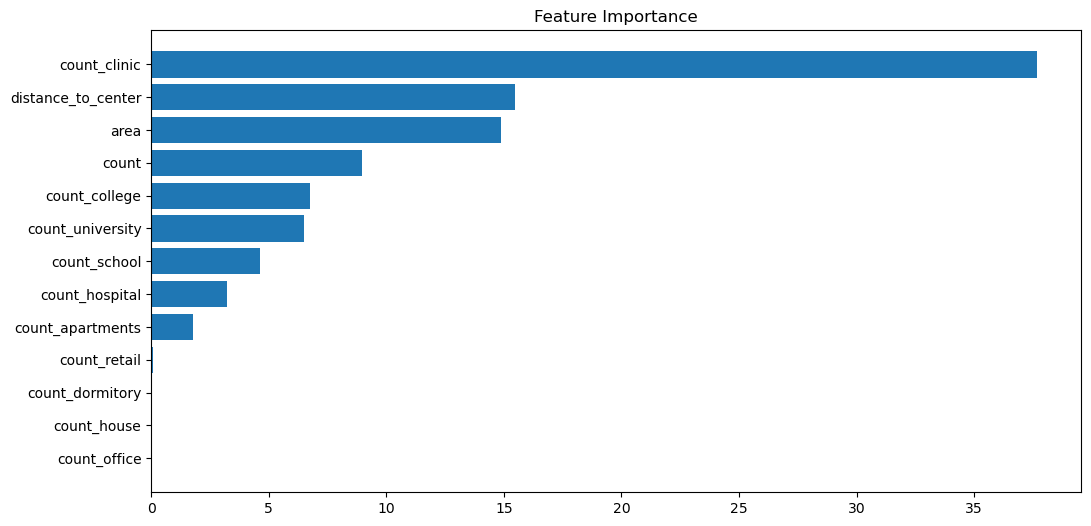

In [101]:
feature_importance = boost.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_train.columns)[sorted_idx])
plt.title('Feature Importance');

Результат кэтбуста: <br>
1.04 на кросс-валидации <br>
Для НАО результат - 1.

# Итог

### Сводная таблица

| Модель                   | Кросс-валидация         | Предикт НАО (пос Сосенское) | 
| :----------------------  | :---------------------- | :-------------------------- |
| LinearRegression1        | 1.28                    |2                            |
| LinearRegression2        | 0.99                    |8                            |
| Pipeline (lr with Scaler)| 0.99                    |8                           |
| Pipeline(PLSreg)         | 1.15                    |5                            |
| Catboost                 | 1.04                    |1                            |

In [102]:
mean_absolute_error(target_test, boost.predict(features_test))

1.1912765091681863

In [103]:
mean_absolute_error(target_test,pd.Series(target_test.median(), index=range(target_test.shape[0])))

1.7647058823529411